# Optuna Tuning | HistGradientBoostingClassifier 
**HistGradientBoostingClassifier ** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataseHistGradientBoostingClassifier t represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [20]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [21]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier

### 0.2 Constants

In [22]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'hgb' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [23]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [24]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [25]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [26]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [27]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [28]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 500, step=50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100, step=10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50, step=5),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 1e-1, log=True),
        "early_stopping": True
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = HistGradientBoostingClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [29]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 12:33:59,701] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [30]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:18,898] Trial 1 finished with value: 0.4802420354861212 and parameters: {'learning_rate': 0.2024726604889709, 'max_iter': 450, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.06586202770595193}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.48047098 0.4816103  0.47728198 0.4825772  0.47926972]
Average score: 0.4802420354861212


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:19,784] Trial 5 finished with value: 0.47678196411283114 and parameters: {'learning_rate': 0.11319140488364358, 'max_iter': 150, 'max_leaf_nodes': 40, 'min_samples_leaf': 16, 'l2_regularization': 0.053114219190520444}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47635241 0.47632501 0.47632501 0.47745369 0.47745369]
Average score: 0.47678196411283114


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:24,357] Trial 7 finished with value: 0.47656170848745455 and parameters: {'learning_rate': 0.10921794404868702, 'max_iter': 450, 'max_leaf_nodes': 70, 'min_samples_leaf': 31, 'l2_regularization': 0.010402834620013809}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:37,960] Trial 9 finished with value: 0.47656170848745455 and parameters: {'learning_rate': 0.08535276115737331, 'max_iter': 200, 'max_leaf_nodes': 40, 'min_samples_leaf': 31, 'l2_regularization': 0.007497509334733769}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:38,957] Trial 0 finished with value: 0.4767762406367801 and parameters: {'learning_rate': 0.043997212713510196, 'max_iter': 100, 'max_leaf_nodes': 40, 'min_samples_leaf': 11, 'l2_regularization': 0.06475160999161536}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47742507 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.4767762406367801


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:42,983] Trial 4 finished with value: 0.4765114134539413 and parameters: {'learning_rate': 0.050127373205561154, 'max_iter': 350, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'l2_regularization': 0.0019378946917597676}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47627021 0.47635241 0.47632501 0.47627021 0.47733922]
Average score: 0.4765114134539413


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:49,072] Trial 8 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.057583913238635126, 'max_iter': 450, 'max_leaf_nodes': 90, 'min_samples_leaf': 31, 'l2_regularization': 0.04790276904225732}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:53,421] Trial 13 finished with value: 0.4765562289961328 and parameters: {'learning_rate': 0.17898050264421145, 'max_iter': 400, 'max_leaf_nodes': 60, 'min_samples_leaf': 46, 'l2_regularization': 0.07414550148712372}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.4765562289961328


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:58,120] Trial 12 finished with value: 0.47718716154133656 and parameters: {'learning_rate': 0.0840541980532419, 'max_iter': 300, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.036283305601853603}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47855011 0.47632501 0.47632501 0.47742507 0.4773106 ]
Average score: 0.47718716154133656


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:34:58,541] Trial 10 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.019677600538900317, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 46, 'l2_regularization': 0.0069729659190649875}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:03,284] Trial 16 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.1684174417066054, 'max_iter': 450, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.0033980654853361983}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:05,963] Trial 15 finished with value: 0.4773330059057604 and parameters: {'learning_rate': 0.2992221926843172, 'max_iter': 350, 'max_leaf_nodes': 90, 'min_samples_leaf': 36, 'l2_regularization': 0.00029603963666990956}. Best is trial 1 with value: 0.4802420354861212.


Cross validation scores: [0.47605088 0.47957964 0.47627021 0.47739646 0.47736784]
Average score: 0.4773330059057604


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:11,482] Trial 17 finished with value: 0.485560832139954 and parameters: {'learning_rate': 0.2958697941567095, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.0001915299121694318}. Best is trial 17 with value: 0.485560832139954.


Cross validation scores: [0.48644922 0.48945514 0.48005355 0.48916252 0.48268373]
Average score: 0.485560832139954


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:12,918] Trial 18 finished with value: 0.4789653900500726 and parameters: {'learning_rate': 0.1798858642843203, 'max_iter': 300, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.02508456612759027}. Best is trial 17 with value: 0.485560832139954.


Cross validation scores: [0.47957964 0.47828175 0.478401   0.48034241 0.47822214]
Average score: 0.4789653900500726


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:15,576] Trial 14 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.011116924790646972, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 46, 'l2_regularization': 0.000880735293916965}. Best is trial 17 with value: 0.485560832139954.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:20,148] Trial 2 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.017878378470253087, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 16, 'l2_regularization': 0.0005555636409780974}. Best is trial 17 with value: 0.485560832139954.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:21,288] Trial 19 finished with value: 0.4782239480574283 and parameters: {'learning_rate': 0.2368552097270712, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 21, 'l2_regularization': 0.00012149150245168958}. Best is trial 17 with value: 0.485560832139954.
[I 2025-01-16 12:35:21,360] Trial 6 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.017270432026419834, 'max_iter': 350, 'max_leaf_nodes': 80, 'min_samples_leaf': 36, 'l2_regularization': 0.01068660294998061}. Best is trial 17 with value: 0.485560832139954.


Cross validation scores: [0.47837118 0.47739646 0.47852028 0.47849045 0.47834137]
Average score: 0.4782239480574283
Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:25,606] Trial 20 finished with value: 0.48586554445752383 and parameters: {'learning_rate': 0.2963000367509789, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00011047100794271598}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48533523 0.48644922 0.48529761 0.49056021 0.48168545]
Average score: 0.48586554445752383


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:30,690] Trial 24 finished with value: 0.47913587390791185 and parameters: {'learning_rate': 0.22662534616850394, 'max_iter': 500, 'max_leaf_nodes': 30, 'min_samples_leaf': 11, 'l2_regularization': 0.001164924566307998}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47846063 0.48278414 0.47739646 0.47739646 0.47964169]
Average score: 0.47913587390791185


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:33,038] Trial 23 finished with value: 0.48069314949581177 and parameters: {'learning_rate': 0.22570320177348618, 'max_iter': 450, 'max_leaf_nodes': 70, 'min_samples_leaf': 6, 'l2_regularization': 0.003981102369506209}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48473384 0.48230197 0.47728198 0.481045   0.47810296]
Average score: 0.48069314949581177


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:35,546] Trial 11 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.019772650888755974, 'max_iter': 200, 'max_leaf_nodes': 60, 'min_samples_leaf': 26, 'l2_regularization': 0.0005810358221056038}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:37,244] Trial 22 finished with value: 0.4775854306774433 and parameters: {'learning_rate': 0.1386718836121457, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.0002574864203688063}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47849045 0.47736784 0.47736784 0.47843081 0.47627021]
Average score: 0.4775854306774433


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:39,798] Trial 26 finished with value: 0.48511085528093456 and parameters: {'learning_rate': 0.2901547734288205, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00020485234802695594}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.49073246 0.48544818 0.48237071 0.48602426 0.48097867]
Average score: 0.48511085528093456


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:49,748] Trial 28 finished with value: 0.4819430827667476 and parameters: {'learning_rate': 0.2557449181227774, 'max_iter': 500, 'max_leaf_nodes': 80, 'min_samples_leaf': 6, 'l2_regularization': 0.004016134303804052}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48360387 0.48261166 0.48144374 0.48422123 0.47783491]
Average score: 0.4819430827667476


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:52,268] Trial 25 finished with value: 0.47656170848745455 and parameters: {'learning_rate': 0.07195533866681353, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 16, 'l2_regularization': 0.00023371215939962082}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:55,012] Trial 27 finished with value: 0.47653954596403 and parameters: {'learning_rate': 0.13639213061306468, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 21, 'l2_regularization': 0.00010222148080109719}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47629761 0.47632501 0.47632501 0.47632501 0.47742507]
Average score: 0.47653954596403


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:35:57,843] Trial 31 finished with value: 0.4840608549843325 and parameters: {'learning_rate': 0.2928206118768667, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00020604056856129592}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48529761 0.48296585 0.47998944 0.48912083 0.48293054]
Average score: 0.4840608549843325


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:00,302] Trial 30 finished with value: 0.47673763562517124 and parameters: {'learning_rate': 0.13724638561806907, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 11, 'l2_regularization': 0.00042798463989855674}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47629761 0.47629761 0.47742507 0.4762428  0.47742507]
Average score: 0.47673763562517124


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:02,604] Trial 21 finished with value: 0.47656170848745455 and parameters: {'learning_rate': 0.03317281608697339, 'max_iter': 500, 'max_leaf_nodes': 70, 'min_samples_leaf': 11, 'l2_regularization': 0.0021828752780483807}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:02,878] Trial 3 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.011503453796178769, 'max_iter': 250, 'max_leaf_nodes': 80, 'min_samples_leaf': 41, 'l2_regularization': 0.02096052862991466}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:04,034] Trial 33 finished with value: 0.4806210258537381 and parameters: {'learning_rate': 0.2890729126046411, 'max_iter': 500, 'max_leaf_nodes': 80, 'min_samples_leaf': 16, 'l2_regularization': 0.00016597401537550308}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48151034 0.48059967 0.48034241 0.48027817 0.48037454]
Average score: 0.4806210258537381


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:05,286] Trial 32 finished with value: 0.47802804054526105 and parameters: {'learning_rate': 0.18423778672797805, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 11, 'l2_regularization': 0.0003955089326577652}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47742507 0.47849045 0.47733922 0.47951762 0.47736784]
Average score: 0.47802804054526105


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:13,815] Trial 36 finished with value: 0.4775675352428152 and parameters: {'learning_rate': 0.20547294529527033, 'max_iter': 100, 'max_leaf_nodes': 80, 'min_samples_leaf': 16, 'l2_regularization': 0.0014198768381988038}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.47843081 0.47629761 0.47745369 0.47722475 0.47843081]
Average score: 0.4775675352428152


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:15,168] Trial 34 finished with value: 0.48125162890887846 and parameters: {'learning_rate': 0.15543107090482255, 'max_iter': 450, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.000817916014671914}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48134393 0.47923875 0.48018186 0.48189055 0.48360305]
Average score: 0.48125162890887846


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:17,062] Trial 38 finished with value: 0.4836130743392764 and parameters: {'learning_rate': 0.2678177078263263, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.0002203775546111024}. Best is trial 20 with value: 0.48586554445752383.


Cross validation scores: [0.48548587 0.48429426 0.48121098 0.48724498 0.47982928]
Average score: 0.4836130743392764


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:19,014] Trial 40 finished with value: 0.4937966020668572 and parameters: {'learning_rate': 0.29410253762760835, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.00010784212170065756}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.49006176 0.49200629 0.49371039 0.50047407 0.4927305 ]
Average score: 0.4937966020668572
Cross validation scores: [0.48268061 0.48271511 0.47926972 0.48131068 0.47899119]
Average score: 0.48099346054522163


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:19,198] Trial 39 finished with value: 0.48099346054522163 and parameters: {'learning_rate': 0.21602224928043995, 'max_iter': 450, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00016052682770869236}. Best is trial 40 with value: 0.4937966020668572.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:20,361] Trial 35 finished with value: 0.4765450260287601 and parameters: {'learning_rate': 0.11252685522376735, 'max_iter': 350, 'max_leaf_nodes': 90, 'min_samples_leaf': 11, 'l2_regularization': 0.000351751505468

Cross validation scores: [0.47632501 0.47632501 0.47742507 0.47632501 0.47632501]
Average score: 0.4765450260287601


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:30,962] Trial 29 finished with value: 0.476545269440081 and parameters: {'learning_rate': 0.03643236471087806, 'max_iter': 450, 'max_leaf_nodes': 90, 'min_samples_leaf': 6, 'l2_regularization': 0.00015131283308977478}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.47632501 0.47632501 0.47632501 0.47629761 0.47745369]
Average score: 0.476545269440081


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:33,032] Trial 41 finished with value: 0.4803330926601884 and parameters: {'learning_rate': 0.252801158703107, 'max_iter': 450, 'max_leaf_nodes': 100, 'min_samples_leaf': 11, 'l2_regularization': 0.0001740712419983424}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.47930069 0.48271511 0.48261166 0.47908399 0.47795402]
Average score: 0.4803330926601884


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:35,038] Trial 42 finished with value: 0.48026348464061713 and parameters: {'learning_rate': 0.199363585905919, 'max_iter': 500, 'max_leaf_nodes': 80, 'min_samples_leaf': 6, 'l2_regularization': 0.0004408851597447877}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.4816103  0.48167699 0.478401   0.48137719 0.47825195]
Average score: 0.48026348464061713


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:35,564] Trial 45 finished with value: 0.48887088849933213 and parameters: {'learning_rate': 0.24663420442918924, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.00013644068792142573}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.48945523 0.4882374  0.488821   0.4919749  0.48586592]
Average score: 0.48887088849933213


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:46,125] Trial 44 finished with value: 0.48062264916467 and parameters: {'learning_rate': 0.15422150847553534, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.00010799399643257375}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.48458704 0.47828175 0.47917683 0.47998944 0.48107818]
Average score: 0.48062264916467


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:53,177] Trial 43 finished with value: 0.4765562284227244 and parameters: {'learning_rate': 0.09477260161132083, 'max_iter': 450, 'max_leaf_nodes': 90, 'min_samples_leaf': 16, 'l2_regularization': 0.000722349814072704}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47629761 0.47745369]
Average score: 0.4765562284227244


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:54,448] Trial 48 finished with value: 0.4839157329021556 and parameters: {'learning_rate': 0.2971665269886245, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.0001983117187231505}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.48339069 0.48537286 0.48317802 0.48484768 0.48278942]
Average score: 0.4839157329021556


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:57,278] Trial 50 finished with value: 0.48552908867614003 and parameters: {'learning_rate': 0.20160884891038833, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.00014088218941747988}. Best is trial 40 with value: 0.4937966020668572.


Cross validation scores: [0.48790285 0.48356683 0.48649496 0.48521968 0.48446112]
Average score: 0.48552908867614003


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:36:58,824] Trial 49 finished with value: 0.49475447044533805 and parameters: {'learning_rate': 0.2681451781445568, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0002131004719955949}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.49765136 0.49394587 0.48760553 0.49930303 0.49526655]
Average score: 0.49475447044533805


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:06,610] Trial 47 finished with value: 0.4765559850114035 and parameters: {'learning_rate': 0.12152436573034711, 'max_iter': 450, 'max_leaf_nodes': 80, 'min_samples_leaf': 21, 'l2_regularization': 0.09543990204381635}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47742507]
Average score: 0.4765559850114035


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:15,848] Trial 37 finished with value: 0.47656170848745455 and parameters: {'learning_rate': 0.02657563877765309, 'max_iter': 400, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.0005762662537525616}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.47656170848745455


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:24,656] Trial 55 finished with value: 0.48572954343813535 and parameters: {'learning_rate': 0.26157702417225476, 'max_iter': 150, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.013988195045738732}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.4920958  0.48891276 0.48141261 0.48653424 0.47969231]
Average score: 0.48572954343813535


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:29,602] Trial 52 finished with value: 0.4805001043816256 and parameters: {'learning_rate': 0.2408221329570052, 'max_iter': 200, 'max_leaf_nodes': 70, 'min_samples_leaf': 11, 'l2_regularization': 0.00010372003065791623}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48047098 0.48174372 0.47822214 0.48378192 0.47828175]
Average score: 0.4805001043816256


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:30,158] Trial 46 finished with value: 0.4767261868381241 and parameters: {'learning_rate': 0.05941055284650183, 'max_iter': 350, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0003040121894371006}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47742507 0.47629761 0.47632501 0.4762154  0.47736784]
Average score: 0.4767261868381241


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:31,468] Trial 53 finished with value: 0.478431775900323 and parameters: {'learning_rate': 0.16405003319189285, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 6, 'l2_regularization': 0.0002724695315410942}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47846063 0.47843081 0.47736784 0.48050314 0.47739646]
Average score: 0.478431775900323


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:31,970] Trial 54 finished with value: 0.4850971233870059 and parameters: {'learning_rate': 0.20596249454415486, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.00014929883108017331}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48342209 0.48786234 0.48552518 0.48349443 0.48518158]
Average score: 0.4850971233870059


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:41,748] Trial 57 finished with value: 0.4820880031789566 and parameters: {'learning_rate': 0.23338021842405113, 'max_iter': 400, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'l2_regularization': 0.000525903274946265}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48014978 0.48590879 0.48250832 0.48303652 0.47883661]
Average score: 0.4820880031789566


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:47,964] Trial 59 finished with value: 0.4829841657113385 and parameters: {'learning_rate': 0.2621280299395024, 'max_iter': 100, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'l2_regularization': 0.03140018760384872}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48830928 0.48418474 0.48147704 0.47868215 0.48226762]
Average score: 0.4829841657113385


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:49,538] Trial 58 finished with value: 0.48496927986725086 and parameters: {'learning_rate': 0.2548931595421421, 'max_iter': 150, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.01173227495859332}. Best is trial 49 with value: 0.49475447044533805.
[I 2025-01-16 12:37:49,542] Trial 61 finished with value: 0.48170061028902894 and parameters: {'learning_rate': 0.2718290391172867, 'max_iter': 150, 'max_leaf_nodes': 40, 'min_samples_leaf': 6, 'l2_regularization': 0.002418220621281217}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.4861424  0.48708642 0.48407537 0.48552518 0.48201703]Cross validation scores: [0.48261166 0.48154365 0.48066406 0.48243949 0.4812442 ]
Average score: 0.48170061028902894

Average score: 0.48496927986725086


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:53,126] Trial 56 finished with value: 0.47656170848745455 and parameters: {'learning_rate': 0.185036329976278, 'max_iter': 300, 'max_leaf_nodes': 90, 'min_samples_leaf': 41, 'l2_regularization': 0.00033096304588909757}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47635241 0.47635241 0.47745369 0.47632501 0.47632501]
Average score: 0.47656170848745455


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:54,470] Trial 60 finished with value: 0.48216824324808644 and parameters: {'learning_rate': 0.22650598063641125, 'max_iter': 200, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.018816946937831387}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48213034 0.48563681 0.48363945 0.47960533 0.47982928]
Average score: 0.48216824324808644


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:37:58,009] Trial 62 finished with value: 0.4833872870721086 and parameters: {'learning_rate': 0.1930374668090514, 'max_iter': 100, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.005780202362339296}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48429426 0.48342618 0.48328429 0.48407537 0.48185634]
Average score: 0.4833872870721086


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:05,993] Trial 64 finished with value: 0.4797932187605712 and parameters: {'learning_rate': 0.23333741747095582, 'max_iter': 450, 'max_leaf_nodes': 30, 'min_samples_leaf': 11, 'l2_regularization': 0.014078754075790349}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.4773106  0.48281867 0.48082516 0.478401   0.47961066]
Average score: 0.4797932187605712


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:11,848] Trial 65 finished with value: 0.47797978084293435 and parameters: {'learning_rate': 0.1489564402230638, 'max_iter': 300, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.00025957730981683683}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47828175 0.47713889 0.47816255 0.47713889 0.47917683]
Average score: 0.47797978084293435


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:15,089] Trial 66 finished with value: 0.47910961190574336 and parameters: {'learning_rate': 0.29743409594567427, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 26, 'l2_regularization': 0.0073829395795319604}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47736784 0.4817771  0.47961066 0.47942462 0.47736784]
Average score: 0.47910961190574336


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:16,282] Trial 69 finished with value: 0.4890833890468119 and parameters: {'learning_rate': 0.26988692405430925, 'max_iter': 200, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00010023346058090305}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48996845 0.48767771 0.48701709 0.49007225 0.49068144]
Average score: 0.4890833890468119


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:17,315] Trial 63 finished with value: 0.47902304355710024 and parameters: {'learning_rate': 0.1716696231965019, 'max_iter': 150, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00013554569693869923}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47954863 0.48167699 0.4762154  0.47936264 0.47831156]
Average score: 0.47902304355710024


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:18,397] Trial 68 finished with value: 0.4871263555972912 and parameters: {'learning_rate': 0.208849355485293, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.00018802436103129195}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48417755 0.48587034 0.48729771 0.49142896 0.48685723]
Average score: 0.4871263555972912


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:25,322] Trial 67 finished with value: 0.48273320670042513 and parameters: {'learning_rate': 0.25540589503878647, 'max_iter': 200, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00012167749579845312}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48458704 0.48353275 0.48147704 0.48411181 0.47995739]
Average score: 0.48273320670042513


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:34,798] Trial 70 finished with value: 0.48750716591651244 and parameters: {'learning_rate': 0.21807420908034378, 'max_iter': 250, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'l2_regularization': 0.00014555125463487206}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.488821   0.49315947 0.48177255 0.48771853 0.48606428]
Average score: 0.48750716591651244


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:38,150] Trial 72 finished with value: 0.4863893106488346 and parameters: {'learning_rate': 0.23790699138976282, 'max_iter': 350, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.00012967550760535073}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.4844747  0.48637725 0.48692821 0.48894671 0.48521968]
Average score: 0.4863893106488346


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:41,030] Trial 74 finished with value: 0.4889112591401756 and parameters: {'learning_rate': 0.2747140143179604, 'max_iter': 150, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00017949311223300804}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48945523 0.48829243 0.48784111 0.48937007 0.48959746]
Average score: 0.4889112591401756


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:43,142] Trial 73 finished with value: 0.48183028774758113 and parameters: {'learning_rate': 0.27060736187917944, 'max_iter': 200, 'max_leaf_nodes': 60, 'min_samples_leaf': 6, 'l2_regularization': 0.00010016246486717117}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48233633 0.48243949 0.48141046 0.48422123 0.47874392]
Average score: 0.48183028774758113


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:44,405] Trial 71 finished with value: 0.47963330779019697 and parameters: {'learning_rate': 0.1879501541994602, 'max_iter': 300, 'max_leaf_nodes': 70, 'min_samples_leaf': 6, 'l2_regularization': 0.00023830253408863315}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48063186 0.47942462 0.47837118 0.48254275 0.47719613]
Average score: 0.47963330779019697


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:38:45,529] Trial 75 finished with value: 0.47949120257076777 and parameters: {'learning_rate': 0.21232379390845157, 'max_iter': 200, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.048672317139938394}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48040668 0.48171035 0.47708165 0.48021396 0.47804338]
Average score: 0.47949120257076777


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:39:31,870] Trial 79 finished with value: 0.487134146545122 and parameters: {'learning_rate': 0.2456865797906824, 'max_iter': 350, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00018216447504514096}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48669772 0.4832415  0.48529594 0.48975413 0.49068144]
Average score: 0.487134146545122


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:39:39,200] Trial 82 finished with value: 0.4866991914973413 and parameters: {'learning_rate': 0.21295411992496227, 'max_iter': 300, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.0003661321397058388}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48187725 0.48810576 0.48903752 0.48741831 0.48705711]
Average score: 0.4866991914973413


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:39:41,205] Trial 78 finished with value: 0.48618346894749165 and parameters: {'learning_rate': 0.22527344552999928, 'max_iter': 250, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'l2_regularization': 0.0001228096732114913}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.49041967 0.48586935 0.48280956 0.48710878 0.48470998]
Average score: 0.48618346894749165


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:39:42,894] Trial 81 finished with value: 0.48244180927443103 and parameters: {'learning_rate': 0.17683261358638006, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.0002302365088571189}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48462372 0.481959   0.47883661 0.48392976 0.48285995]
Average score: 0.48244180927443103


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:39:45,414] Trial 76 finished with value: 0.4795161742950702 and parameters: {'learning_rate': 0.1306397911708811, 'max_iter': 250, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'l2_regularization': 0.00019265679493173977}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48053531 0.47728198 0.48164364 0.47816255 0.47995739]
Average score: 0.4795161742950702


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:02,808] Trial 80 finished with value: 0.47797724751269877 and parameters: {'learning_rate': 0.10068430367781514, 'max_iter': 200, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.0001408261124765747}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47843081 0.47736784 0.47852028 0.47719613 0.47837118]
Average score: 0.47797724751269877


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:06,383] Trial 83 finished with value: 0.4827159525149094 and parameters: {'learning_rate': 0.27464575195474145, 'max_iter': 150, 'max_leaf_nodes': 60, 'min_samples_leaf': 6, 'l2_regularization': 0.0001696204611673668}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48349721 0.4857124  0.47939363 0.48613991 0.47883661]
Average score: 0.4827159525149094


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:11,030] Trial 85 finished with value: 0.47887176697827905 and parameters: {'learning_rate': 0.1634997751001086, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 6, 'l2_regularization': 0.00018608531503724133}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47849045 0.47843081 0.47843081 0.4816103  0.47739646]
Average score: 0.47887176697827905


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:13,345] Trial 87 finished with value: 0.4821729846453616 and parameters: {'learning_rate': 0.2402388439683983, 'max_iter': 350, 'max_leaf_nodes': 80, 'min_samples_leaf': 6, 'l2_regularization': 0.00047113947997864345}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48363945 0.48131068 0.48360387 0.48331974 0.47899119]
Average score: 0.4821729846453616


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:18,010] Trial 88 finished with value: 0.48656378617497714 and parameters: {'learning_rate': 0.21577270148184483, 'max_iter': 300, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00036724083640492103}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48428885 0.48657354 0.4866522  0.48808692 0.48721742]
Average score: 0.48656378617497714


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:19,457] Trial 77 finished with value: 0.47633597337075617 and parameters: {'learning_rate': 0.043339448976960425, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 36, 'l2_regularization': 0.0001580911443214037}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:22,983] Trial 89 finished with value: 0.4834992861499086 and parameters: {'learning_rate': 0.1967442607460928, 'max_iter': 350, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00019808840422000983}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48275418 0.48548587 0.48303652 0.48514734 0.48107252]
Average score: 0.4834992861499086


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:26,939] Trial 90 finished with value: 0.4883139247988847 and parameters: {'learning_rate': 0.276287826949411, 'max_iter': 300, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00011559260558438189}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.49265559 0.48622127 0.48579151 0.49011557 0.48678567]
Average score: 0.4883139247988847


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:30,622] Trial 84 finished with value: 0.47694023308009525 and parameters: {'learning_rate': 0.0721622960576856, 'max_iter': 200, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'l2_regularization': 0.00031311484667907735}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47736784 0.47629761 0.47745369 0.4762428  0.47733922]
Average score: 0.47694023308009525


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:32,674] Trial 91 finished with value: 0.48535900261208254 and parameters: {'learning_rate': 0.2149456765254639, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.00017632198262365547}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48432599 0.48899591 0.48454915 0.47972513 0.48919883]
Average score: 0.48535900261208254


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:33,898] Trial 92 finished with value: 0.48102950624413177 and parameters: {'learning_rate': 0.2475539479875352, 'max_iter': 200, 'max_leaf_nodes': 50, 'min_samples_leaf': 6, 'l2_regularization': 0.00022922426415506754}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48151034 0.48388893 0.47852028 0.48440393 0.47682405]
Average score: 0.48102950624413177


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:35,687] Trial 93 finished with value: 0.4894561262542506 and parameters: {'learning_rate': 0.2812724936409678, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00015030416014091247}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.4910697  0.48532617 0.48816905 0.49173447 0.49098124]
Average score: 0.4894561262542506


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:40:43,383] Trial 94 finished with value: 0.4772150521332158 and parameters: {'learning_rate': 0.20213516533419038, 'max_iter': 300, 'max_leaf_nodes': 70, 'min_samples_leaf': 31, 'l2_regularization': 0.00026992444271188224}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47632501 0.47635241 0.47745369 0.47849045 0.47745369]
Average score: 0.4772150521332158


[I 2025-01-16 12:40:44,881] Trial 95 finished with value: 0.4767306957325584 and parameters: {'learning_rate': 0.2755295182496576, 'max_iter': 150, 'max_leaf_nodes': 80, 'min_samples_leaf': 41, 'l2_regularization': 0.00011985763462995379}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.4773106  0.47635241 0.47736784 0.47632501 0.47629761]
Average score: 0.4767306957325584
Cross validation scores: [0.49164765 0.48590829 0.49205084 0.48924254 0.48955446]
Average score: 0.48968075696308455


[I 2025-01-16 12:40:45,115] Trial 96 finished with value: 0.48968075696308455 and parameters: {'learning_rate': 0.25399893754083064, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.0001055602957570825}. Best is trial 49 with value: 0.49475447044533805.
[I 2025-01-16 12:40:45,745] Trial 99 finished with value: 0.4887155095164242 and parameters: {'learning_rate': 0.2766411558026614, 'max_iter': 250, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.00015054657933934423}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48606428 0.4910761  0.48780022 0.49436435 0.48427259]
Average score: 0.4887155095164242


[I 2025-01-16 12:40:46,607] Trial 98 finished with value: 0.48521930601738805 and parameters: {'learning_rate': 0.21879477286651466, 'max_iter': 300, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'l2_regularization': 0.00016849642888831329}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.48903752 0.48257815 0.48342209 0.48717731 0.48388146]
Average score: 0.48521930601738805


[I 2025-01-16 12:40:47,394] Trial 97 finished with value: 0.4782253573760752 and parameters: {'learning_rate': 0.15002009662722005, 'max_iter': 350, 'max_leaf_nodes': 60, 'min_samples_leaf': 6, 'l2_regularization': 0.000136389052149803}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47849045 0.47846063 0.47629761 0.48056748 0.4773106 ]
Average score: 0.4782253573760752


[I 2025-01-16 12:40:49,082] Trial 51 finished with value: 0.4765393019418605 and parameters: {'learning_rate': 0.014047193057614867, 'max_iter': 250, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.000125780990836497}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47629761 0.47635241 0.47632501 0.47632501 0.47739646]
Average score: 0.4765393019418605


[I 2025-01-16 12:41:01,208] Trial 86 finished with value: 0.4765562289961328 and parameters: {'learning_rate': 0.010242857272228349, 'max_iter': 300, 'max_leaf_nodes': 70, 'min_samples_leaf': 1, 'l2_regularization': 0.00028038295684183973}. Best is trial 49 with value: 0.49475447044533805.


Cross validation scores: [0.47632501 0.47635241 0.47632501 0.47632501 0.47745369]
Average score: 0.4765562289961328


In [31]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 49
Best Parameters: {'learning_rate': 0.2681451781445568, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0002131004719955949}
Best Value: 0.49475447044533805


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [32]:
optuna.visualization.plot_optimization_history(study)

In [33]:
optuna.visualization.plot_slice(study)

In [34]:
optuna.visualization.plot_param_importances(study)

In [35]:
optuna.visualization.plot_parallel_coordinate(study)

In [36]:
optuna.visualization.plot_contour(study)

In [37]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [38]:
# Fit best model on the training set
best_params = study.best_params

model = HistGradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.0002131004719955949,
                               learning_rate=0.2681451781445568, max_iter=500,
                               max_leaf_nodes=100, min_samples_leaf=1,
                               random_state=38)

In [39]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [40]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.919212708562294
Test accuracy:  0.8991980604252144


In [41]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.99      0.95     19510
      Early-readmission       0.14      0.02      0.04      1938

               accuracy                           0.90     21448
              macro avg       0.53      0.50      0.49     21448
           weighted avg       0.84      0.90      0.86     21448



In [42]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

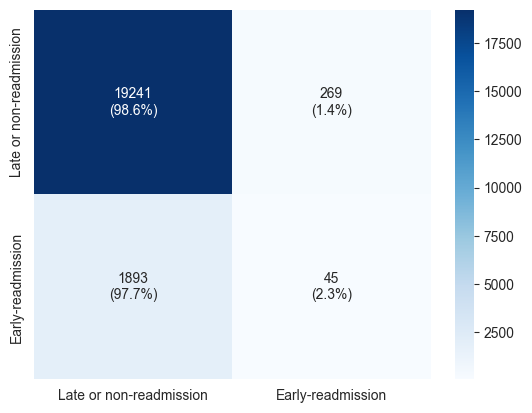

In [43]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [44]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 500, step=50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100, step=10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50, step=5),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 1e-1, log=True),
        "early_stopping": True
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        HistGradientBoostingClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [45]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 12:41:08,454] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [46]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:15,406] Trial 0 finished with value: 0.489753465600539 and parameters: {'learning_rate': 0.22388274482518117, 'max_iter': 300, 'max_leaf_nodes': 30, 'min_samples_leaf': 36, 'l2_regularization': 0.005240710153816349}. Best is trial 0 with value: 0.489753465600539.


Cross validation scores: [0.48403588 0.48957486 0.5006148  0.49626084 0.47828094]
Average score: 0.489753465600539


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:17,317] Trial 5 finished with value: 0.4858880661537735 and parameters: {'learning_rate': 0.16155962124915502, 'max_iter': 300, 'max_leaf_nodes': 40, 'min_samples_leaf': 46, 'l2_regularization': 0.07084147251013789}. Best is trial 0 with value: 0.489753465600539.


Cross validation scores: [0.48707468 0.48588106 0.49045034 0.48898175 0.4770525 ]
Average score: 0.4858880661537735


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:20,952] Trial 6 finished with value: 0.49854853373598046 and parameters: {'learning_rate': 0.013320782193510338, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.05018969521769799}. Best is trial 6 with value: 0.49854853373598046.


Cross validation scores: [0.50066762 0.50287986 0.51559475 0.49413309 0.47946735]
Average score: 0.49854853373598046


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:27,752] Trial 3 finished with value: 0.4984949782516829 and parameters: {'learning_rate': 0.017462967339941623, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.015750524640260926}. Best is trial 6 with value: 0.49854853373598046.


Cross validation scores: [0.49541502 0.50488445 0.51443063 0.49661925 0.48112553]
Average score: 0.4984949782516829


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:30,594] Trial 4 finished with value: 0.4987313641924421 and parameters: {'learning_rate': 0.01601761950058893, 'max_iter': 500, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.005954971257638638}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.49418664 0.50585455 0.51473977 0.49729201 0.48158386]
Average score: 0.4987313641924421


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:35,312] Trial 7 finished with value: 0.4861759385598988 and parameters: {'learning_rate': 0.04795559223400159, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 31, 'l2_regularization': 0.0517622383154151}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.48519106 0.48590236 0.49470059 0.48602026 0.47906544]
Average score: 0.4861759385598988


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:42,290] Trial 8 finished with value: 0.4928668956211423 and parameters: {'learning_rate': 0.06529630193515552, 'max_iter': 400, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.00017779172240537492}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.48777105 0.4946069  0.50864159 0.4898153  0.48349965]
Average score: 0.4928668956211423


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:45,406] Trial 11 finished with value: 0.4751624797024861 and parameters: {'learning_rate': 0.21454817489931113, 'max_iter': 200, 'max_leaf_nodes': 70, 'min_samples_leaf': 16, 'l2_regularization': 0.00033118432586566864}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.46803276 0.47854624 0.47794429 0.47687239 0.47441671]
Average score: 0.4751624797024861


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:50,672] Trial 1 finished with value: 0.49335527460708795 and parameters: {'learning_rate': 0.021634215139924348, 'max_iter': 450, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.024110147527682757}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.4853008  0.49652382 0.50767995 0.49273385 0.48453796]
Average score: 0.49335527460708795


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:41:55,017] Trial 13 finished with value: 0.49474376226586025 and parameters: {'learning_rate': 0.048524148244883734, 'max_iter': 500, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.022258223496566924}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.48793383 0.50049358 0.51000593 0.49477491 0.48051056]
Average score: 0.49474376226586025


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:03,222] Trial 16 finished with value: 0.47332055131435646 and parameters: {'learning_rate': 0.2556272866713415, 'max_iter': 250, 'max_leaf_nodes': 80, 'min_samples_leaf': 21, 'l2_regularization': 0.0070787985060870515}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.46545574 0.47079178 0.47980371 0.47980871 0.47074282]
Average score: 0.47332055131435646
Cross validation scores: [0.48458022 0.49554939 0.50690379 0.49316543 0.48254844]
Average score: 0.4925494521552139


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:03,444] Trial 14 finished with value: 0.4925494521552139 and parameters: {'learning_rate': 0.05189055748137634, 'max_iter': 500, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.03815244905096738}. Best is trial 4 with value: 0.4987313641924421.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:09,302] Trial 17 finished with value: 0.48829550866273264 and parameters: {'learning_rate': 0.10034524536393864, 'max_iter': 100, 'max_leaf_nodes': 50, 'min_samples_leaf': 26, 'l2_regularization': 0.0012718795817592886}

Cross validation scores: [0.4849026  0.48524258 0.49424307 0.49486488 0.48222441]
Average score: 0.48829550866273264
Cross validation scores: [0.48220373 0.48519955 0.49527677 0.48789651 0.48523756]
Average score: 0.487162825618381


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:09,576] Trial 10 finished with value: 0.487162825618381 and parameters: {'learning_rate': 0.051262840833233674, 'max_iter': 200, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0005555093453967467}. Best is trial 4 with value: 0.4987313641924421.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:16,300] Trial 19 finished with value: 0.4977827603426947 and parameters: {'learning_rate': 0.031673751697807326, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.003021573125599817

Cross validation scores: [0.49519836 0.50475049 0.51150419 0.49705006 0.4804107 ]
Average score: 0.4977827603426947


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:17,350] Trial 18 finished with value: 0.49776624384269164 and parameters: {'learning_rate': 0.010542467903026223, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0011727403010746798}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.50130658 0.50238788 0.51511316 0.49183758 0.47818602]
Average score: 0.49776624384269164


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:20,120] Trial 2 finished with value: 0.4928652647651989 and parameters: {'learning_rate': 0.011675042288694547, 'max_iter': 200, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'l2_regularization': 0.00014708418849389998}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.48447471 0.49473865 0.50946307 0.49254458 0.48310531]
Average score: 0.4928652647651989


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:26,667] Trial 21 finished with value: 0.49429728902041214 and parameters: {'learning_rate': 0.03473208717639466, 'max_iter': 350, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.0024319252215591856}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.49039609 0.49741734 0.51020111 0.4946029  0.47886899]
Average score: 0.49429728902041214


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:27,870] Trial 9 finished with value: 0.48553130680918966 and parameters: {'learning_rate': 0.02929662727662346, 'max_iter': 450, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00026604971860418503}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.47905725 0.48299946 0.49776147 0.48234957 0.48548878]
Average score: 0.48553130680918966


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:30,874] Trial 22 finished with value: 0.4900289437802236 and parameters: {'learning_rate': 0.08676595075639178, 'max_iter': 150, 'max_leaf_nodes': 40, 'min_samples_leaf': 31, 'l2_regularization': 0.001261052643978037}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.48860945 0.49076263 0.49785524 0.49418368 0.47873372]
Average score: 0.4900289437802236


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:32,892] Trial 23 finished with value: 0.49821831281933615 and parameters: {'learning_rate': 0.025922822023322908, 'max_iter': 450, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.00953495100724542}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.49623385 0.50540085 0.51262969 0.49805109 0.47877607]
Average score: 0.49821831281933615


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:41,912] Trial 15 finished with value: 0.4893610483859364 and parameters: {'learning_rate': 0.020693963699302088, 'max_iter': 400, 'max_leaf_nodes': 70, 'min_samples_leaf': 11, 'l2_regularization': 0.07208372517894686}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.48485404 0.48552136 0.50281256 0.48700206 0.48661522]
Average score: 0.4893610483859364


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:45,138] Trial 25 finished with value: 0.4942070963473535 and parameters: {'learning_rate': 0.03835420095909038, 'max_iter': 300, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.03405492923733011}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.4876194  0.49632268 0.50947346 0.49589599 0.48172396]
Average score: 0.4942070963473535


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:45,821] Trial 20 finished with value: 0.49647533966314245 and parameters: {'learning_rate': 0.013575463826676652, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 46, 'l2_regularization': 0.00889046494072927}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.49161932 0.49874878 0.51251667 0.49779637 0.48169557]
Average score: 0.49647533966314245


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:42:56,389] Trial 28 finished with value: 0.49794656438316337 and parameters: {'learning_rate': 0.01708110487733376, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.014912996811683643}. Best is trial 4 with value: 0.4987313641924421.


Cross validation scores: [0.49469267 0.50521571 0.51360257 0.49637729 0.47984459]
Average score: 0.49794656438316337


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:01,791] Trial 29 finished with value: 0.5001177486251059 and parameters: {'learning_rate': 0.013492345346973997, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.00578501599954426}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.4999265  0.50824792 0.51520093 0.49401495 0.48319845]
Average score: 0.5001177486251059


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:06,150] Trial 27 finished with value: 0.49520478026378034 and parameters: {'learning_rate': 0.022523465043170616, 'max_iter': 400, 'max_leaf_nodes': 20, 'min_samples_leaf': 16, 'l2_regularization': 0.09673714116299424}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48698927 0.49840303 0.51206261 0.49609914 0.48246985]
Average score: 0.49520478026378034


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:15,762] Trial 12 finished with value: 0.48663611479915225 and parameters: {'learning_rate': 0.016577518021871893, 'max_iter': 200, 'max_leaf_nodes': 80, 'min_samples_leaf': 6, 'l2_regularization': 0.015260160219789322}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.47974203 0.48443466 0.50148779 0.48451813 0.48299796]
Average score: 0.48663611479915225


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:23,973] Trial 32 finished with value: 0.49875765341587136 and parameters: {'learning_rate': 0.012582123672954759, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.0046748352105843655}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.50023428 0.50296922 0.5141498  0.49621301 0.48022196]
Average score: 0.49875765341587136


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:25,247] Trial 24 finished with value: 0.4927608773661684 and parameters: {'learning_rate': 0.015095651953518458, 'max_iter': 350, 'max_leaf_nodes': 40, 'min_samples_leaf': 16, 'l2_regularization': 0.0042110911523018085}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48879563 0.49387193 0.50639821 0.49099644 0.48374219]
Average score: 0.4927608773661684


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:27,900] Trial 30 finished with value: 0.49547151356383656 and parameters: {'learning_rate': 0.017232999258146624, 'max_iter': 300, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.015385047120173351}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.4882823  0.50001226 0.51171295 0.49706347 0.48028659]
Average score: 0.49547151356383656


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:30,844] Trial 31 finished with value: 0.49141916845258277 and parameters: {'learning_rate': 0.021492697075742757, 'max_iter': 250, 'max_leaf_nodes': 30, 'min_samples_leaf': 11, 'l2_regularization': 0.025513074949672244}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48572296 0.49332311 0.50499331 0.49175634 0.48130012]
Average score: 0.49141916845258277


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:34,127] Trial 35 finished with value: 0.4981524957404792 and parameters: {'learning_rate': 0.025448870759838513, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.004770702895008703}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49433888 0.50569369 0.5130138  0.49661925 0.48109685]
Average score: 0.4981524957404792


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:35,261] Trial 37 finished with value: 0.4962847888568822 and parameters: {'learning_rate': 0.12600306686944798, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'l2_regularization': 0.002413450833777707}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49053598 0.50309326 0.50805791 0.49600658 0.48373023]
Average score: 0.4962847888568822


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:48,839] Trial 38 finished with value: 0.499498921496218 and parameters: {'learning_rate': 0.012989191616175184, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.011893679287764778}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49971042 0.50598077 0.51706305 0.49412341 0.48061695]
Average score: 0.499498921496218


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:51,748] Trial 39 finished with value: 0.49851526037745647 and parameters: {'learning_rate': 0.019668802824890152, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.00651373240330031}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49755817 0.50254833 0.51467418 0.49674614 0.48104948]
Average score: 0.49851526037745647


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:56,310] Trial 33 finished with value: 0.49558013092902764 and parameters: {'learning_rate': 0.013803280241869017, 'max_iter': 100, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.0006572515993604405}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49112773 0.49642463 0.51258347 0.49359102 0.4841738 ]
Average score: 0.49558013092902764


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:43:59,973] Trial 34 finished with value: 0.4964633957593379 and parameters: {'learning_rate': 0.010141190565214089, 'max_iter': 100, 'max_leaf_nodes': 30, 'min_samples_leaf': 41, 'l2_regularization': 0.0074665518830307614}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.491278   0.49521735 0.51426831 0.49663116 0.48492216]
Average score: 0.4964633957593379


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:03,311] Trial 42 finished with value: 0.4985929082769271 and parameters: {'learning_rate': 0.04139189119906656, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.00010000032503557627}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49741446 0.50297553 0.51554672 0.49877974 0.47824809]
Average score: 0.4985929082769271


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:04,888] Trial 40 finished with value: 0.49843481309168103 and parameters: {'learning_rate': 0.014283787794154339, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.005392725538515016}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49649667 0.50305817 0.51519912 0.49633986 0.48108025]
Average score: 0.49843481309168103


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:15,037] Trial 44 finished with value: 0.4989330625927235 and parameters: {'learning_rate': 0.017980786453198214, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.010943869911337634}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49936648 0.50365182 0.51454303 0.49614959 0.48095439]
Average score: 0.4989330625927235


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:25,647] Trial 26 finished with value: 0.4876673339883927 and parameters: {'learning_rate': 0.010492184323013432, 'max_iter': 150, 'max_leaf_nodes': 60, 'min_samples_leaf': 36, 'l2_regularization': 0.0018231819511091768}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.4829756  0.48815903 0.49892007 0.48859869 0.47968328]
Average score: 0.4876673339883927


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:27,899] Trial 46 finished with value: 0.4910942058289237 and parameters: {'learning_rate': 0.06611521061336549, 'max_iter': 200, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.002027393232625559}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48417084 0.49375387 0.50246498 0.49220876 0.48287259]
Average score: 0.4910942058289237


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:29,266] Trial 48 finished with value: 0.49789763300724743 and parameters: {'learning_rate': 0.020895393608811555, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.009271398950215037}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49593203 0.50447667 0.51333396 0.49646673 0.47927877]
Average score: 0.49789763300724743
Cross validation scores: [0.48525747 0.4938172  0.50894149 0.49408652 0.48233612]
Average score: 0.4928877603701262


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:29,488] Trial 43 finished with value: 0.4928877603701262 and parameters: {'learning_rate': 0.025045555940740535, 'max_iter': 150, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'l2_regularization': 0.012244497547455916}. Best is trial 29 with value: 0.5001177486251059.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:32,320] Trial 41 finished with value: 0.4959750828883805 and parameters: {'learning_rate': 0.012520651596480619, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'l2_regularization': 0.000669339133497085

Cross validation scores: [0.48821472 0.49591623 0.51323675 0.49647934 0.48602838]
Average score: 0.4959750828883805


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:44,467] Trial 52 finished with value: 0.49854282054757776 and parameters: {'learning_rate': 0.017739698504080983, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.020444583136654322}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.4992889  0.50384788 0.51443486 0.49532573 0.47981673]
Average score: 0.49854282054757776


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:49,659] Trial 50 finished with value: 0.4984019475777998 and parameters: {'learning_rate': 0.011790491387199266, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.003125807511665723}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49917175 0.50165332 0.51484778 0.49574305 0.48059385]
Average score: 0.4984019475777998


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:53,866] Trial 49 finished with value: 0.4967131304095149 and parameters: {'learning_rate': 0.01867223424717771, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 16, 'l2_regularization': 0.011974189977814634}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48922424 0.50097743 0.51221431 0.49642897 0.4847207 ]
Average score: 0.4967131304095149


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:55,820] Trial 53 finished with value: 0.4954306755274399 and parameters: {'learning_rate': 0.029434142324737525, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'l2_regularization': 0.011000425797364655}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48799293 0.49908178 0.50883725 0.4970746  0.48416681]
Average score: 0.4954306755274399


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:56,536] Trial 47 finished with value: 0.49339390968985386 and parameters: {'learning_rate': 0.015726429871457028, 'max_iter': 450, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.0059461241531622265}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48567059 0.49751414 0.5089354  0.49272188 0.48212755]
Average score: 0.49339390968985386


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:57,473] Trial 36 finished with value: 0.4907702427299757 and parameters: {'learning_rate': 0.011871429240456075, 'max_iter': 200, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'l2_regularization': 0.003605493908661067}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.48508454 0.49199764 0.50446587 0.48964063 0.48266253]
Average score: 0.4907702427299757


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:44:58,920] Trial 51 finished with value: 0.4963010028139034 and parameters: {'learning_rate': 0.01461007984784587, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 11, 'l2_regularization': 0.00427524994926104}. Best is trial 29 with value: 0.5001177486251059.


Cross validation scores: [0.49231913 0.49773741 0.51464601 0.49309401 0.48370846]
Average score: 0.4963010028139034


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:00,737] Trial 54 finished with value: 0.5005993596902555 and parameters: {'learning_rate': 0.013117674703282645, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.03307697848353434}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50052495 0.50889865 0.51629481 0.49482936 0.48244903]
Average score: 0.5005993596902555


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:09,026] Trial 59 finished with value: 0.4980576377743876 and parameters: {'learning_rate': 0.04024594243391709, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.005532317055315995}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49388007 0.50480593 0.51449622 0.4977236  0.47938237]
Average score: 0.4980576377743876


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:12,553] Trial 60 finished with value: 0.496381200480746 and parameters: {'learning_rate': 0.06119459764279421, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'l2_regularization': 0.003901694354901634}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49001307 0.49919884 0.51034937 0.49898014 0.48336459]
Average score: 0.496381200480746


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:12,924] Trial 58 finished with value: 0.49919410583172785 and parameters: {'learning_rate': 0.01914097220290851, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.00010048766527190336}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49987667 0.50345485 0.51447747 0.49545241 0.48270913]
Average score: 0.49919410583172785


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:22,094] Trial 57 finished with value: 0.4986527804711606 and parameters: {'learning_rate': 0.015566302983203283, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.016962809152644098}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49591643 0.50556703 0.51419202 0.49694863 0.4806398 ]
Average score: 0.4986527804711606


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:32,596] Trial 64 finished with value: 0.4989362835207835 and parameters: {'learning_rate': 0.019551507346311454, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.00024523450737359647}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49874132 0.50332583 0.51484778 0.49603369 0.4817328 ]
Average score: 0.4989362835207835


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:32,945] Trial 61 finished with value: 0.49709647177358507 and parameters: {'learning_rate': 0.013843583095433584, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 16, 'l2_regularization': 0.027708584840493312}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49120659 0.49921018 0.51552357 0.49778713 0.48175489]
Average score: 0.49709647177358507


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:36,925] Trial 62 finished with value: 0.4988818727029162 and parameters: {'learning_rate': 0.012830541572880967, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.058636302831786315}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.4976219  0.50376701 0.51480536 0.49604856 0.48216654]
Average score: 0.4988818727029162


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:43,962] Trial 65 finished with value: 0.4992919150684515 and parameters: {'learning_rate': 0.011177968150334193, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.0009452234109398691}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50023001 0.50553337 0.51504753 0.49420486 0.48144381]
Average score: 0.4992919150684515


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:49,842] Trial 67 finished with value: 0.498745133619744 and parameters: {'learning_rate': 0.03033521821500855, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.00043824728866965064}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49627007 0.50728268 0.51375962 0.4973673  0.479046  ]
Average score: 0.498745133619744


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:45:50,994] Trial 63 finished with value: 0.49680141092709584 and parameters: {'learning_rate': 0.016148316811772232, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.033096611381618096}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49153324 0.50138904 0.51104066 0.49693652 0.48310759]
Average score: 0.49680141092709584


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:03,049] Trial 55 finished with value: 0.4850831243988731 and parameters: {'learning_rate': 0.02374061373109743, 'max_iter': 250, 'max_leaf_nodes': 90, 'min_samples_leaf': 11, 'l2_regularization': 0.007729373473329057}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48323661 0.4798059  0.49976171 0.48559467 0.47701674]
Average score: 0.4850831243988731


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:04,014] Trial 69 finished with value: 0.4990393684371637 and parameters: {'learning_rate': 0.020798638371897486, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.0001346579850637341}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49739527 0.5046767  0.51504467 0.49630214 0.48177806]
Average score: 0.4990393684371637


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:06,496] Trial 68 finished with value: 0.4991090367829668 and parameters: {'learning_rate': 0.012813616450715149, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.06350504923083768}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49899626 0.50360886 0.51412649 0.49617534 0.48263824]
Average score: 0.4991090367829668


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:08,575] Trial 70 finished with value: 0.49941284684067105 and parameters: {'learning_rate': 0.011181538540194465, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.00026056968079813113}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49928915 0.50517648 0.51474187 0.49416912 0.48368761]
Average score: 0.49941284684067105


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:09,082] Trial 66 finished with value: 0.49549019656327015 and parameters: {'learning_rate': 0.0186224634548444, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 11, 'l2_regularization': 0.00020461156946271274}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.4884485  0.496458   0.5124067  0.49601065 0.48412713]
Average score: 0.49549019656327015


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:20,533] Trial 73 finished with value: 0.4988161745502069 and parameters: {'learning_rate': 0.019638081272356174, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.0001390740760355017}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49856372 0.50273624 0.51484778 0.49549093 0.48244221]
Average score: 0.4988161745502069


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:23,043] Trial 71 finished with value: 0.4968891282461823 and parameters: {'learning_rate': 0.016951020873980344, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.00010302782651299418}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49147002 0.49984229 0.51273381 0.49744447 0.48295505]
Average score: 0.4968891282461823


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:24,639] Trial 76 finished with value: 0.49839368003136153 and parameters: {'learning_rate': 0.011269103331144918, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.0009737109864042135}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50057886 0.50303458 0.51461008 0.49215328 0.4815916 ]
Average score: 0.49839368003136153


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:28,558] Trial 45 finished with value: 0.4862954095818631 and parameters: {'learning_rate': 0.012022236338776629, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.02213815114523016}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.47949661 0.48522351 0.49850651 0.48104221 0.48720821]
Average score: 0.4862954095818631


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:35,926] Trial 56 finished with value: 0.4940553735763581 and parameters: {'learning_rate': 0.01012389342835453, 'max_iter': 400, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.04665493061004121}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48705501 0.49664678 0.50967313 0.4933743  0.48352764]
Average score: 0.4940553735763581


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:39,592] Trial 78 finished with value: 0.4980997746739998 and parameters: {'learning_rate': 0.01127541577415209, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.0001669994928115412}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50080924 0.50303458 0.51129259 0.49454896 0.48081351]
Average score: 0.4980997746739998


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:40,746] Trial 79 finished with value: 0.4990484633584938 and parameters: {'learning_rate': 0.012666842101831765, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.07264121087209646}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49776214 0.50698385 0.51447975 0.49379711 0.48221947]
Average score: 0.4990484633584938


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:44,146] Trial 77 finished with value: 0.4984323808714529 and parameters: {'learning_rate': 0.014783786556651411, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.04847306406665636}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49622131 0.50295843 0.51550699 0.49689829 0.48057689]
Average score: 0.4984323808714529


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:44,893] Trial 80 finished with value: 0.49836283452032976 and parameters: {'learning_rate': 0.010016509995982466, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.00011820488305639093}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50053991 0.50181044 0.51603195 0.49420486 0.47922701]
Average score: 0.49836283452032976


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:46,878] Trial 74 finished with value: 0.496396140831628 and parameters: {'learning_rate': 0.013276282535758627, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.09956564378456692}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48963787 0.50197558 0.51169303 0.49767326 0.48100097]
Average score: 0.496396140831628


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:51,059] Trial 84 finished with value: 0.4940924312132102 and parameters: {'learning_rate': 0.17143545823418962, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.07811448394740539}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48992003 0.49388718 0.50697109 0.49593326 0.48375059]
Average score: 0.4940924312132102


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:51,993] Trial 81 finished with value: 0.4983088229914543 and parameters: {'learning_rate': 0.013784962759276006, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.00031881755937699323}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50101914 0.50078198 0.51327941 0.49424987 0.48221371]
Average score: 0.4983088229914543


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:46:56,742] Trial 83 finished with value: 0.4996690870594195 and parameters: {'learning_rate': 0.012789031813331261, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.07623838052410585}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.5010115  0.50552722 0.51631759 0.49467562 0.48081351]
Average score: 0.4996690870594195


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:02,518] Trial 85 finished with value: 0.4991520862879165 and parameters: {'learning_rate': 0.011960496755109917, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.060473423559471315}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50019575 0.50510802 0.51465408 0.49429571 0.48150688]
Average score: 0.4991520862879165


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:10,591] Trial 88 finished with value: 0.4988893205343915 and parameters: {'learning_rate': 0.010867979541172077, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.00017016478989861523}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.5011468  0.50540364 0.51271057 0.49420486 0.48098072]
Average score: 0.4988893205343915


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:13,684] Trial 89 finished with value: 0.5005853941148587 and parameters: {'learning_rate': 0.012562512197058203, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.08443662488132057}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50075603 0.50740307 0.51636055 0.4934807  0.48492663]
Average score: 0.5005853941148587


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:20,895] Trial 90 finished with value: 0.49968060073806936 and parameters: {'learning_rate': 0.011851379866507307, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.059638762130226494}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50032343 0.50539769 0.51605462 0.49287653 0.48375074]
Average score: 0.49968060073806936


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:21,831] Trial 82 finished with value: 0.4962040770279357 and parameters: {'learning_rate': 0.015826683077798775, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 16, 'l2_regularization': 0.00020516843915767473}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48869332 0.50010962 0.51329929 0.49623385 0.48268429]
Average score: 0.4962040770279357


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:30,198] Trial 91 finished with value: 0.49942416504597115 and parameters: {'learning_rate': 0.014281929786512068, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.05981353048230074}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50145882 0.50268555 0.51504755 0.49437636 0.48355255]
Average score: 0.49942416504597115


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:38,800] Trial 87 finished with value: 0.4943153188728194 and parameters: {'learning_rate': 0.014765097527808697, 'max_iter': 100, 'max_leaf_nodes': 30, 'min_samples_leaf': 16, 'l2_regularization': 0.030279647836176597}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48848273 0.49588301 0.51184542 0.49385274 0.48151269]
Average score: 0.4943153188728194


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:40,206] Trial 93 finished with value: 0.49841412282979214 and parameters: {'learning_rate': 0.010781035479652059, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.042387242001283604}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50133098 0.5052091  0.51221156 0.493916   0.47940297]
Average score: 0.49841412282979214


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:41,080] Trial 72 finished with value: 0.4910001901187638 and parameters: {'learning_rate': 0.011163657921298697, 'max_iter': 150, 'max_leaf_nodes': 60, 'min_samples_leaf': 11, 'l2_regularization': 0.0001393508941653862}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48606067 0.48990991 0.50867603 0.48774894 0.4826054 ]
Average score: 0.4910001901187638
Cross validation scores: [0.48859519 0.49760695 0.51013212 0.49549947 0.48198728]
Average score: 0.4947642025424231


[I 2025-01-16 12:47:41,261] Trial 86 finished with value: 0.4947642025424231 and parameters: {'learning_rate': 0.012765952961374675, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 31, 'l2_regularization': 0.040490386152779584}. Best is trial 54 with value: 0.5005993596902555.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:47:46,780] Trial 92 finished with value: 0.4975190511922355 and parameters: {'learning_rate': 0.011832371977412014, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 31, 'l2_regularization': 0.0820843354930771

Cross validation scores: [0.49302248 0.49966096 0.51638768 0.49734256 0.48118159]
Average score: 0.4975190511922355


[I 2025-01-16 12:47:48,548] Trial 95 finished with value: 0.49983975981974627 and parameters: {'learning_rate': 0.013996596132317407, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.05992346808441433}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50053206 0.50326701 0.51640499 0.4935365  0.48545823]
Average score: 0.49983975981974627


[I 2025-01-16 12:47:55,963] Trial 96 finished with value: 0.49933444915536257 and parameters: {'learning_rate': 0.014957440031897598, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.051570549698213404}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50194622 0.50216913 0.51546344 0.49412341 0.48297005]
Average score: 0.49933444915536257


[I 2025-01-16 12:47:56,931] Trial 98 finished with value: 0.5002169150789595 and parameters: {'learning_rate': 0.012000536224052118, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.0008136954943438091}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.5008549  0.50702724 0.514523   0.49439483 0.48428461]
Average score: 0.5002169150789595


[I 2025-01-16 12:47:57,538] Trial 99 finished with value: 0.4981897534678015 and parameters: {'learning_rate': 0.010596431201070833, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.0015300174600597545}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.50105947 0.5048202  0.51234208 0.49397927 0.47874775]
Average score: 0.4981897534678015


[I 2025-01-16 12:48:00,720] Trial 94 finished with value: 0.49578930879445454 and parameters: {'learning_rate': 0.01670558513583004, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 21, 'l2_regularization': 0.09172058339608992}. Best is trial 54 with value: 0.5005993596902555.
[I 2025-01-16 12:48:00,723] Trial 75 finished with value: 0.4855507270496635 and parameters: {'learning_rate': 0.010945447648872692, 'max_iter': 150, 'max_leaf_nodes': 70, 'min_samples_leaf': 26, 'l2_regularization': 0.0004043482831026445}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.48377127 0.48404523 0.49910775 0.48438567 0.47644372]
Average score: 0.4855507270496635
Cross validation scores: [0.48874223 0.49885588 0.5129099  0.49790196 0.48053657]
Average score: 0.49578930879445454


[I 2025-01-16 12:48:00,938] Trial 97 finished with value: 0.4983575201854958 and parameters: {'learning_rate': 0.013285013112484503, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.0341098268079834}. Best is trial 54 with value: 0.5005993596902555.


Cross validation scores: [0.49868834 0.50322212 0.51340624 0.49599729 0.48047362]
Average score: 0.4983575201854958


In [47]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 54
Best Parameters: {'learning_rate': 0.013117674703282645, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.03307697848353434}
Best Value: 0.5005993596902555


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [48]:
optuna.visualization.plot_optimization_history(study)

In [49]:
optuna.visualization.plot_slice(study)

In [50]:
optuna.visualization.plot_param_importances(study)

In [51]:
optuna.visualization.plot_parallel_coordinate(study)

In [52]:
optuna.visualization.plot_contour(study)

In [53]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [54]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    HistGradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=0.03307697848353434,
                                                learning_rate=0.013117674703282645,
                                                max_leaf_nodes=10,
                                                min_samples_leaf=16,
                                                random_state=38))])

In [55]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [56]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6527525227295434
Test accuracy:  0.6467269675494218


In [57]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.66      0.77     19510
      Early-readmission       0.13      0.53      0.21      1938

               accuracy                           0.65     21448
              macro avg       0.53      0.60      0.49     21448
           weighted avg       0.86      0.65      0.72     21448



In [58]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

In [59]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

<Axes: >

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [60]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 500, step=50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100, step=10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50, step=5),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 1e-1, log=True),
        "early_stopping": True
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        HistGradientBoostingClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [61]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 12:48:08,249] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [62]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:49:18,829] Trial 4 finished with value: 0.481865843301042 and parameters: {'learning_rate': 0.2442730554461009, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.005839281267482517}. Best is trial 4 with value: 0.481865843301042.


Cross validation scores: [0.48223328 0.48226762 0.48053531 0.48462372 0.47966929]
Average score: 0.481865843301042


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:49:40,933] Trial 6 finished with value: 0.47940163248160106 and parameters: {'learning_rate': 0.07782374213903592, 'max_iter': 100, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.0030559995653877776}. Best is trial 4 with value: 0.481865843301042.


Cross validation scores: [0.48131068 0.48021396 0.47936264 0.47725336 0.47886752]
Average score: 0.47940163248160106


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:50:04,982] Trial 2 finished with value: 0.48048241627502525 and parameters: {'learning_rate': 0.06593817084507177, 'max_iter': 100, 'max_leaf_nodes': 60, 'min_samples_leaf': 11, 'l2_regularization': 0.0009834553282438646}. Best is trial 4 with value: 0.481865843301042.


Cross validation scores: [0.48147704 0.48243949 0.48137719 0.47828175 0.47883661]
Average score: 0.48048241627502525


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:51:17,304] Trial 3 finished with value: 0.4810893992902418 and parameters: {'learning_rate': 0.05924044954263394, 'max_iter': 200, 'max_leaf_nodes': 60, 'min_samples_leaf': 41, 'l2_regularization': 0.00011090777845191124}. Best is trial 4 with value: 0.481865843301042.


Cross validation scores: [0.48310724 0.48219896 0.4835683  0.47696716 0.47960533]
Average score: 0.4810893992902418


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:51:19,924] Trial 0 finished with value: 0.49296055274845185 and parameters: {'learning_rate': 0.23137351922489252, 'max_iter': 400, 'max_leaf_nodes': 70, 'min_samples_leaf': 36, 'l2_regularization': 0.016809993822167378}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.50138549 0.48409844 0.50137468 0.48818884 0.48975531]
Average score: 0.49296055274845185


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:52:12,924] Trial 10 finished with value: 0.48811346804993827 and parameters: {'learning_rate': 0.2941354818617546, 'max_iter': 250, 'max_leaf_nodes': 40, 'min_samples_leaf': 46, 'l2_regularization': 0.04009634999732909}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.49007225 0.49329878 0.48705711 0.48423494 0.48590427]
Average score: 0.48811346804993827


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:52:17,079] Trial 8 finished with value: 0.48736851563304723 and parameters: {'learning_rate': 0.21021347733508017, 'max_iter': 350, 'max_leaf_nodes': 40, 'min_samples_leaf': 36, 'l2_regularization': 0.0002208956338697262}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48366008 0.49045774 0.4910697  0.48583042 0.48582464]
Average score: 0.48736851563304723


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:53:08,478] Trial 5 finished with value: 0.4810404050266778 and parameters: {'learning_rate': 0.0334379922401669, 'max_iter': 300, 'max_leaf_nodes': 60, 'min_samples_leaf': 41, 'l2_regularization': 0.0005511031575923576}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.481045   0.48444052 0.48154365 0.47831156 0.4798613 ]
Average score: 0.4810404050266778


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:53:17,055] Trial 1 finished with value: 0.47990365881718244 and parameters: {'learning_rate': 0.013662649897515528, 'max_iter': 400, 'max_leaf_nodes': 40, 'min_samples_leaf': 26, 'l2_regularization': 0.06600142869102876}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.47716751 0.4857124  0.4816103  0.47616057 0.47886752]
Average score: 0.47990365881718244


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:53:51,142] Trial 7 finished with value: 0.47993532441124864 and parameters: {'learning_rate': 0.03499489253707646, 'max_iter': 200, 'max_leaf_nodes': 100, 'min_samples_leaf': 36, 'l2_regularization': 0.00019731296891888487}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48101183 0.48289524 0.47908399 0.47920779 0.47747777]
Average score: 0.47993532441124864


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:54:55,509] Trial 11 finished with value: 0.48026014801730543 and parameters: {'learning_rate': 0.051393667806790354, 'max_iter': 150, 'max_leaf_nodes': 90, 'min_samples_leaf': 31, 'l2_regularization': 0.008801595865691958}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48005355 0.48114456 0.48131068 0.48134393 0.47744802]
Average score: 0.48026014801730543


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:55:17,460] Trial 17 finished with value: 0.4802269592141 and parameters: {'learning_rate': 0.1790015082843816, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 46, 'l2_regularization': 0.02555811537157229}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48144374 0.4801177  0.48043883 0.47822214 0.48091238]
Average score: 0.4802269592141


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:55:26,788] Trial 15 finished with value: 0.49045889801892006 and parameters: {'learning_rate': 0.01355807307400551, 'max_iter': 100, 'max_leaf_nodes': 70, 'min_samples_leaf': 6, 'l2_regularization': 0.0001268440631546993}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.49701437 0.49390952 0.48915675 0.49022658 0.48198727]
Average score: 0.49045889801892006


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:56:08,822] Trial 14 finished with value: 0.4884029959323872 and parameters: {'learning_rate': 0.15381242680018897, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 21, 'l2_regularization': 0.08008576900705446}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48903051 0.48614216 0.4927469  0.48988264 0.48421276]
Average score: 0.4884029959323872


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:56:44,568] Trial 18 finished with value: 0.4878246617756667 and parameters: {'learning_rate': 0.2704437384913943, 'max_iter': 350, 'max_leaf_nodes': 30, 'min_samples_leaf': 46, 'l2_regularization': 0.0416078030537609}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48727087 0.48774103 0.49160613 0.48771853 0.48478675]
Average score: 0.4878246617756667


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:57:30,050] Trial 19 finished with value: 0.48268680112259404 and parameters: {'learning_rate': 0.1298017196346976, 'max_iter': 250, 'max_leaf_nodes': 30, 'min_samples_leaf': 41, 'l2_regularization': 0.024929966683680343}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.4862944  0.48310724 0.4824739  0.48021396 0.48134451]
Average score: 0.48268680112259404


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:58:56,606] Trial 12 finished with value: 0.48811467030900735 and parameters: {'learning_rate': 0.08386180401158054, 'max_iter': 450, 'max_leaf_nodes': 70, 'min_samples_leaf': 21, 'l2_regularization': 0.003231067375255409}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48586592 0.48915765 0.49380148 0.4879639  0.4837844 ]
Average score: 0.48811467030900735


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:59:16,427] Trial 9 finished with value: 0.47998135533614894 and parameters: {'learning_rate': 0.0100802841062909, 'max_iter': 450, 'max_leaf_nodes': 80, 'min_samples_leaf': 21, 'l2_regularization': 0.003628079110004926}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.47807316 0.48537286 0.48147704 0.47602345 0.47896027]
Average score: 0.47998135533614894


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 12:59:25,640] Trial 16 finished with value: 0.4884103493493388 and parameters: {'learning_rate': 0.11350449859027448, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 31, 'l2_regularization': 0.008656996909322695}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.49372192 0.48467163 0.49032152 0.48976972 0.48356695]
Average score: 0.4884103493493388


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:00:08,557] Trial 22 finished with value: 0.4798837545363194 and parameters: {'learning_rate': 0.0433083479307545, 'max_iter': 200, 'max_leaf_nodes': 70, 'min_samples_leaf': 6, 'l2_regularization': 0.0014690978893721455}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.47992536 0.48233633 0.48027817 0.47708165 0.47979727]
Average score: 0.4798837545363194


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:01:21,518] Trial 25 finished with value: 0.4812125222544589 and parameters: {'learning_rate': 0.09795209061811168, 'max_iter': 150, 'max_leaf_nodes': 50, 'min_samples_leaf': 16, 'l2_regularization': 0.01434891192061672}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48317802 0.48310724 0.48024606 0.47911493 0.48041636]
Average score: 0.4812125222544589


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:02:05,490] Trial 13 finished with value: 0.48765955214262496 and parameters: {'learning_rate': 0.06834655538938599, 'max_iter': 450, 'max_leaf_nodes': 90, 'min_samples_leaf': 26, 'l2_regularization': 0.08421332214775198}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.48359738 0.48682599 0.49342907 0.4863401  0.48810522]
Average score: 0.48765955214262496


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:02:21,608] Trial 27 finished with value: 0.47846728189373466 and parameters: {'learning_rate': 0.030451595749090878, 'max_iter': 350, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.00010203576921221937}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.47716751 0.48147704 0.47957964 0.47618798 0.47792424]
Average score: 0.47846728189373466


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:02:26,120] Trial 24 finished with value: 0.48863627995808756 and parameters: {'learning_rate': 0.010485234302064599, 'max_iter': 150, 'max_leaf_nodes': 80, 'min_samples_leaf': 31, 'l2_regularization': 0.00041152415392024376}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.49850843 0.4929206  0.48278942 0.48548692 0.48347603]
Average score: 0.48863627995808756


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:03:12,254] Trial 21 finished with value: 0.47963584651163665 and parameters: {'learning_rate': 0.024992318267888218, 'max_iter': 400, 'max_leaf_nodes': 70, 'min_samples_leaf': 11, 'l2_regularization': 0.013869129385111272}. Best is trial 0 with value: 0.49296055274845185.


Cross validation scores: [0.4777456  0.48097867 0.48134393 0.47828175 0.47982928]
Average score: 0.47963584651163665


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:03:49,867] Trial 31 finished with value: 0.49916364207580843 and parameters: {'learning_rate': 0.01084573709406366, 'max_iter': 100, 'max_leaf_nodes': 80, 'min_samples_leaf': 36, 'l2_regularization': 0.000507380024513573}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.50055772 0.50073894 0.49632032 0.49948961 0.49871162]
Average score: 0.49916364207580843


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:04:17,924] Trial 26 finished with value: 0.48032036596593103 and parameters: {'learning_rate': 0.018004326883322964, 'max_iter': 300, 'max_leaf_nodes': 70, 'min_samples_leaf': 6, 'l2_regularization': 0.0018983116941038494}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.47813275 0.48346169 0.48264613 0.478401   0.47896027]
Average score: 0.48032036596593103


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:04:20,658] Trial 30 finished with value: 0.48940943779059803 and parameters: {'learning_rate': 0.2050689083616634, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 31, 'l2_regularization': 0.004991849758300293}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48904056 0.48507214 0.49356951 0.49090041 0.48846456]
Average score: 0.48940943779059803


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:04:33,756] Trial 32 finished with value: 0.48367855230829565 and parameters: {'learning_rate': 0.013778800130056782, 'max_iter': 150, 'max_leaf_nodes': 50, 'min_samples_leaf': 16, 'l2_regularization': 0.00021221832785092435}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48598575 0.48786234 0.48422123 0.47834137 0.48198207]
Average score: 0.48367855230829565


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:04:51,102] Trial 20 finished with value: 0.48025286244451026 and parameters: {'learning_rate': 0.018087115696962745, 'max_iter': 500, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'l2_regularization': 0.0012842773353944287}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48107818 0.48114456 0.48360387 0.47690992 0.47852779]
Average score: 0.48025286244451026


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:05:01,765] Trial 29 finished with value: 0.4895541510092718 and parameters: {'learning_rate': 0.15245567530361714, 'max_iter': 500, 'max_leaf_nodes': 80, 'min_samples_leaf': 26, 'l2_regularization': 0.011778174135878321}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49486488 0.49242383 0.48798878 0.48807156 0.4844217 ]
Average score: 0.4895541510092718


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:05:08,772] Trial 33 finished with value: 0.4908572219448709 and parameters: {'learning_rate': 0.013702834960062209, 'max_iter': 100, 'max_leaf_nodes': 70, 'min_samples_leaf': 41, 'l2_regularization': 0.000707867194306828}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49769463 0.49563811 0.4909004  0.48701709 0.48303588]
Average score: 0.4908572219448709


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:05:25,052] Trial 28 finished with value: 0.4908618400967474 and parameters: {'learning_rate': 0.11247269466559483, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 31, 'l2_regularization': 0.007032795100007688}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49578036 0.48516007 0.49484868 0.49015893 0.48836115]
Average score: 0.4908618400967474


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:05:31,419] Trial 34 finished with value: 0.4871220460966398 and parameters: {'learning_rate': 0.01779733943253301, 'max_iter': 100, 'max_leaf_nodes': 60, 'min_samples_leaf': 36, 'l2_regularization': 0.00015468429359096435}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49586197 0.49362115 0.48518488 0.48031029 0.48063194]
Average score: 0.4871220460966398


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:05:52,288] Trial 35 finished with value: 0.49286300259934235 and parameters: {'learning_rate': 0.012441043231708039, 'max_iter': 100, 'max_leaf_nodes': 80, 'min_samples_leaf': 6, 'l2_regularization': 0.0003252428468488201}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49764413 0.49250757 0.49419197 0.49310503 0.48686632]
Average score: 0.49286300259934235


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:06:04,082] Trial 23 finished with value: 0.4809473631699717 and parameters: {'learning_rate': 0.02321851223670052, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 16, 'l2_regularization': 0.000488155930372002}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48213034 0.48077992 0.48455039 0.47789446 0.47938171]
Average score: 0.4809473631699717


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:06:23,637] Trial 39 finished with value: 0.48774701774583595 and parameters: {'learning_rate': 0.014283809895382579, 'max_iter': 100, 'max_leaf_nodes': 60, 'min_samples_leaf': 41, 'l2_regularization': 0.0007599665304038155}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49427699 0.49452312 0.48334981 0.48261333 0.48397183]
Average score: 0.48774701774583595


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:07:21,510] Trial 40 finished with value: 0.49277835372994383 and parameters: {'learning_rate': 0.22877319566967733, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 36, 'l2_regularization': 0.0018753102647949237}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49850579 0.49720174 0.49338214 0.49045774 0.48434436]
Average score: 0.49277835372994383


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:07:38,743] Trial 38 finished with value: 0.48910717272739274 and parameters: {'learning_rate': 0.16619703724048435, 'max_iter': 450, 'max_leaf_nodes': 80, 'min_samples_leaf': 26, 'l2_regularization': 0.01401157335335609}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48448013 0.4917797  0.49442833 0.48873732 0.48611039]
Average score: 0.48910717272739274


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:08:01,040] Trial 36 finished with value: 0.47917403858826885 and parameters: {'learning_rate': 0.023987441678078845, 'max_iter': 200, 'max_leaf_nodes': 100, 'min_samples_leaf': 26, 'l2_regularization': 0.0007459419865917364}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.4777456  0.4820275  0.48147704 0.47705303 0.47756703]
Average score: 0.47917403858826885


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:08:05,193] Trial 42 finished with value: 0.48413754716308127 and parameters: {'learning_rate': 0.10058936579784644, 'max_iter': 150, 'max_leaf_nodes': 100, 'min_samples_leaf': 31, 'l2_regularization': 0.022595877360919746}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48606428 0.48273777 0.4900463  0.48360305 0.47823633]
Average score: 0.48413754716308127


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:08:18,194] Trial 37 finished with value: 0.4828230265054261 and parameters: {'learning_rate': 0.04659801744716084, 'max_iter': 300, 'max_leaf_nodes': 70, 'min_samples_leaf': 41, 'l2_regularization': 0.00032198823502824653}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.4861785  0.48189055 0.48335521 0.4812442  0.48144668]
Average score: 0.4828230265054261


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:08:58,199] Trial 45 finished with value: 0.4888430154964841 and parameters: {'learning_rate': 0.22935683154998446, 'max_iter': 200, 'max_leaf_nodes': 60, 'min_samples_leaf': 36, 'l2_regularization': 0.001991284064746602}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49170463 0.49014668 0.48674539 0.49050681 0.48511157]
Average score: 0.4888430154964841


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:09:08,916] Trial 41 finished with value: 0.48843680301727765 and parameters: {'learning_rate': 0.12490608993165464, 'max_iter': 450, 'max_leaf_nodes': 90, 'min_samples_leaf': 36, 'l2_regularization': 0.006432840095450773}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48679909 0.48428907 0.49592717 0.48989921 0.48526949]
Average score: 0.48843680301727765


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:09:25,036] Trial 43 finished with value: 0.48223586316958833 and parameters: {'learning_rate': 0.060452984095611534, 'max_iter': 250, 'max_leaf_nodes': 80, 'min_samples_leaf': 31, 'l2_regularization': 0.0002852849525554988}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48250783 0.48158306 0.48720531 0.47982928 0.48005384]
Average score: 0.48223586316958833


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:09:58,066] Trial 49 finished with value: 0.4907875685353117 and parameters: {'learning_rate': 0.28784066494653626, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 36, 'l2_regularization': 0.004844641885258103}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48925422 0.49034713 0.49139072 0.49461787 0.4883279 ]
Average score: 0.4907875685353117


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:10:10,504] Trial 47 finished with value: 0.49432031842461077 and parameters: {'learning_rate': 0.25663035126578565, 'max_iter': 450, 'max_leaf_nodes': 100, 'min_samples_leaf': 36, 'l2_regularization': 0.0011292173369317942}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49476205 0.49473377 0.50182653 0.49560785 0.4846714 ]
Average score: 0.49432031842461077


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:10:13,408] Trial 46 finished with value: 0.4905775626472743 and parameters: {'learning_rate': 0.19553908928504762, 'max_iter': 300, 'max_leaf_nodes': 90, 'min_samples_leaf': 46, 'l2_regularization': 0.0024631701058802262}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48797998 0.48867141 0.49568268 0.49148025 0.48907349]
Average score: 0.4905775626472743


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:11:24,738] Trial 53 finished with value: 0.4907902791900196 and parameters: {'learning_rate': 0.2336864637081574, 'max_iter': 100, 'max_leaf_nodes': 100, 'min_samples_leaf': 41, 'l2_regularization': 0.0009118070832745015}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48992876 0.4886576  0.50283594 0.48873477 0.48379433]
Average score: 0.4907902791900196


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:12:01,702] Trial 50 finished with value: 0.48870520160184305 and parameters: {'learning_rate': 0.14117316131539018, 'max_iter': 450, 'max_leaf_nodes': 80, 'min_samples_leaf': 31, 'l2_regularization': 0.00031435063841895873}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48694705 0.48876358 0.49071657 0.48928502 0.48781379]
Average score: 0.48870520160184305


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:12:11,886] Trial 44 finished with value: 0.48020518348263563 and parameters: {'learning_rate': 0.010223513788786632, 'max_iter': 400, 'max_leaf_nodes': 80, 'min_samples_leaf': 21, 'l2_regularization': 0.0038739407649181056}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.47807316 0.48644922 0.48040668 0.47716751 0.47892935]
Average score: 0.48020518348263563


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:12:16,683] Trial 54 finished with value: 0.49905133901820103 and parameters: {'learning_rate': 0.26892071993931616, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.001152595345378673}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49796696 0.49871144 0.50425172 0.50241683 0.49190974]
Average score: 0.49905133901820103


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:12:35,956] Trial 55 finished with value: 0.49278880115414286 and parameters: {'learning_rate': 0.18061705032743164, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 46, 'l2_regularization': 0.0005261306348447576}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49930303 0.49256169 0.49568268 0.4919749  0.4844217 ]
Average score: 0.49278880115414286


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:13:00,786] Trial 48 finished with value: 0.4897350127605667 and parameters: {'learning_rate': 0.08453175819453133, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 41, 'l2_regularization': 0.008537012406960188}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49246184 0.48848228 0.4932437  0.48877915 0.4857081 ]
Average score: 0.4897350127605667


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:13:03,467] Trial 56 finished with value: 0.4879847815331219 and parameters: {'learning_rate': 0.24316861940703968, 'max_iter': 400, 'max_leaf_nodes': 70, 'min_samples_leaf': 36, 'l2_regularization': 0.0015037903398582918}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.4849405  0.48683979 0.4908929  0.48743333 0.48981739]
Average score: 0.4879847815331219


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:14:22,858] Trial 59 finished with value: 0.4979312611095092 and parameters: {'learning_rate': 0.2657818702284544, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0012384621177410073}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.50343644 0.49373582 0.50439178 0.49693202 0.49116025]
Average score: 0.4979312611095092


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:14:24,588] Trial 58 finished with value: 0.4920109837178327 and parameters: {'learning_rate': 0.21585649911946148, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 31, 'l2_regularization': 0.0023015503853296513}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49801504 0.4852679  0.49334838 0.49032152 0.49310208]
Average score: 0.4920109837178327


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:14:31,420] Trial 61 finished with value: 0.4910044586504963 and parameters: {'learning_rate': 0.29855803462660835, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.000995426632898757}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49649378 0.4856219  0.49817236 0.48631231 0.48842195]
Average score: 0.4910044586504963


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:14:36,470] Trial 52 finished with value: 0.4866971116912824 and parameters: {'learning_rate': 0.07213127633992418, 'max_iter': 450, 'max_leaf_nodes': 80, 'min_samples_leaf': 36, 'l2_regularization': 0.020167575523679437}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48521027 0.48497898 0.49251887 0.48721742 0.48356002]
Average score: 0.4866971116912824


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:15:30,922] Trial 62 finished with value: 0.4898398792368816 and parameters: {'learning_rate': 0.18356057902803036, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 46, 'l2_regularization': 0.0005950371745523481}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.49265375 0.48816676 0.4961726  0.48823069 0.4839756 ]
Average score: 0.4898398792368816


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:15:46,898] Trial 60 finished with value: 0.4944277082119652 and parameters: {'learning_rate': 0.17277539124132538, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0005240194799140387}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.48878502 0.49314591 0.50684764 0.48940853 0.49395144]
Average score: 0.4944277082119652


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:15:47,527] Trial 65 finished with value: 0.49085270067388126 and parameters: {'learning_rate': 0.27088672821480114, 'max_iter': 300, 'max_leaf_nodes': 40, 'min_samples_leaf': 11, 'l2_regularization': 0.0012283345827407452}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.488821   0.49277683 0.49907346 0.48414048 0.48945173]
Average score: 0.49085270067388126


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:16:36,184] Trial 63 finished with value: 0.4978489497886451 and parameters: {'learning_rate': 0.2482189290123597, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0009838018091338516}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.4992564  0.4977436  0.50543015 0.49689843 0.48991616]
Average score: 0.4978489497886451


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:16:40,603] Trial 64 finished with value: 0.49742645150818354 and parameters: {'learning_rate': 0.250778061211877, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0012792977551327942}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.50103751 0.49439569 0.50031457 0.49230809 0.4990764 ]
Average score: 0.49742645150818354


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:17:05,745] Trial 51 finished with value: 0.4794998708258449 and parameters: {'learning_rate': 0.011870457370429946, 'max_iter': 500, 'max_leaf_nodes': 90, 'min_samples_leaf': 26, 'l2_regularization': 0.05369602792815652}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.4779838  0.48331974 0.48040668 0.47819234 0.47759679]
Average score: 0.4794998708258449


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:17:56,357] Trial 57 finished with value: 0.4805991506020749 and parameters: {'learning_rate': 0.015924515680131455, 'max_iter': 450, 'max_leaf_nodes': 80, 'min_samples_leaf': 41, 'l2_regularization': 0.0003838475073221666}. Best is trial 31 with value: 0.49916364207580843.


Cross validation scores: [0.47902212 0.48335521 0.48254275 0.47936264 0.47871303]
Average score: 0.4805991506020749


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:18:11,728] Trial 68 finished with value: 0.5004313135899403 and parameters: {'learning_rate': 0.2610975813850707, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.00042019123405288264}. Best is trial 68 with value: 0.5004313135899403.


Cross validation scores: [0.5047049  0.49491543 0.50165164 0.50159731 0.49928728]
Average score: 0.5004313135899403


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:18:31,144] Trial 69 finished with value: 0.4910384918700871 and parameters: {'learning_rate': 0.1949360504989235, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00017449359251021427}. Best is trial 68 with value: 0.5004313135899403.


Cross validation scores: [0.49851334 0.48714558 0.49668272 0.4885243  0.48432652]
Average score: 0.4910384918700871


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:18:39,412] Trial 71 finished with value: 0.4952277664709577 and parameters: {'learning_rate': 0.2537731359455428, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0014826627605088992}. Best is trial 68 with value: 0.5004313135899403.


Cross validation scores: [0.4936295  0.49139002 0.5052725  0.49212001 0.4937268 ]
Average score: 0.4952277664709577


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:19:08,816] Trial 72 finished with value: 0.5017802122558346 and parameters: {'learning_rate': 0.27427988041840357, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0008190547306080049}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50624685 0.49939349 0.50778085 0.49826821 0.49721165]
Average score: 0.5017802122558346


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:19:17,994] Trial 67 finished with value: 0.4799899392393544 and parameters: {'learning_rate': 0.03328053090347735, 'max_iter': 250, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.00024664817346538504}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.47889843 0.48114456 0.48462372 0.47789446 0.47738853]
Average score: 0.4799899392393544


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:19:34,400] Trial 66 finished with value: 0.4800562471706784 and parameters: {'learning_rate': 0.011714510021228988, 'max_iter': 400, 'max_leaf_nodes': 70, 'min_samples_leaf': 6, 'l2_regularization': 0.0001366157885741548}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.47810296 0.48451375 0.48154365 0.47725336 0.47886752]
Average score: 0.4800562471706784


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:19:43,506] Trial 70 finished with value: 0.4940939289587627 and parameters: {'learning_rate': 0.16093313499331163, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0010426099867614233}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49045774 0.49399669 0.50790467 0.48519912 0.49291143]
Average score: 0.4940939289587627


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:19:54,733] Trial 74 finished with value: 0.5000339498937979 and parameters: {'learning_rate': 0.2971350664104487, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0004318071178740999}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50548757 0.48798167 0.50170958 0.50274338 0.50224755]
Average score: 0.5000339498937979


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:20:23,924] Trial 73 finished with value: 0.49618391222193586 and parameters: {'learning_rate': 0.20927890332233356, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0006187128140825163}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49689983 0.49245974 0.49776217 0.49720174 0.49659609]
Average score: 0.49618391222193586


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:20:37,766] Trial 76 finished with value: 0.49501545174727396 and parameters: {'learning_rate': 0.2559572350774206, 'max_iter': 350, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0015783048256358518}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49486653 0.48592317 0.50270292 0.5001025  0.49148213]
Average score: 0.49501545174727396


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:21:00,810] Trial 77 finished with value: 0.4947127679490529 and parameters: {'learning_rate': 0.27207037014549046, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.0009440215193179992}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49305552 0.49565281 0.49948961 0.49097021 0.49439569]
Average score: 0.4947127679490529


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:21:33,226] Trial 81 finished with value: 0.5009352985850365 and parameters: {'learning_rate': 0.2971321794891972, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0003606914260218602}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50227427 0.49375093 0.50261641 0.5003786  0.50565629]
Average score: 0.5009352985850365


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:21:37,307] Trial 75 finished with value: 0.48913469838916424 and parameters: {'learning_rate': 0.13780650271623573, 'max_iter': 350, 'max_leaf_nodes': 90, 'min_samples_leaf': 11, 'l2_regularization': 0.0006605835432953231}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.48515102 0.49114926 0.49269081 0.49028917 0.48639322]
Average score: 0.48913469838916424


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:21:40,062] Trial 79 finished with value: 0.4991377981401085 and parameters: {'learning_rate': 0.26505123014654786, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.002925444458899726}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.4985894  0.49623124 0.49599518 0.51247148 0.49240169]
Average score: 0.4991377981401085


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:21:43,022] Trial 78 finished with value: 0.4975661098395115 and parameters: {'learning_rate': 0.22215311254767223, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0008458579844176413}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50088019 0.48951016 0.51175166 0.49019034 0.49549819]
Average score: 0.4975661098395115


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:21:47,912] Trial 80 finished with value: 0.49453879850830196 and parameters: {'learning_rate': 0.2501384718160316, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.0013467841425092379}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49473377 0.49382027 0.50659831 0.48968354 0.48785811]
Average score: 0.49453879850830196


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:22:50,350] Trial 82 finished with value: 0.49330714328052877 and parameters: {'learning_rate': 0.19368645398117104, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 6, 'l2_regularization': 0.00042786624632146604}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49076731 0.48837935 0.50341597 0.49460985 0.48936324]
Average score: 0.49330714328052877


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:23:14,884] Trial 84 finished with value: 0.49980612114069034 and parameters: {'learning_rate': 0.28333420028358447, 'max_iter': 350, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0008493743454272534}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50186102 0.50187722 0.50153281 0.49988783 0.49387172]
Average score: 0.49980612114069034


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:23:25,763] Trial 85 finished with value: 0.4935998397369339 and parameters: {'learning_rate': 0.2967128565141242, 'max_iter': 400, 'max_leaf_nodes': 100, 'min_samples_leaf': 11, 'l2_regularization': 0.0003863615313760108}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49423492 0.49487865 0.49366457 0.49485835 0.49036271]
Average score: 0.4935998397369339


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:23:28,510] Trial 83 finished with value: 0.49917186075284076 and parameters: {'learning_rate': 0.21295487981094516, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0004549705228245981}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50144686 0.48867962 0.50074763 0.50619862 0.49878658]
Average score: 0.49917186075284076


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:23:46,998] Trial 87 finished with value: 0.49482859509450516 and parameters: {'learning_rate': 0.2733330534778287, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00035682198625032203}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49342833 0.48916062 0.50635451 0.4901935  0.49500602]
Average score: 0.49482859509450516


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:24:04,794] Trial 89 finished with value: 0.49996901412737876 and parameters: {'learning_rate': 0.26697048364319514, 'max_iter': 250, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0027362765110084805}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50439178 0.50066504 0.50636484 0.49358569 0.49483771]
Average score: 0.49996901412737876


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:24:07,880] Trial 86 finished with value: 0.49774933736321697 and parameters: {'learning_rate': 0.23323953257969068, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0002621312092455973}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49505476 0.49649559 0.50465555 0.49372482 0.49881597]
Average score: 0.49774933736321697


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:24:42,763] Trial 96 finished with value: 0.4787086052231052 and parameters: {'learning_rate': 0.21497130088859087, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'l2_regularization': 0.00022609381638516777}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.47923875 0.47682405 0.47930069 0.47822214 0.47995739]
Average score: 0.4787086052231052


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:24:55,248] Trial 92 finished with value: 0.5003936420180257 and parameters: {'learning_rate': 0.296064196993816, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0008184137036308076}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50770173 0.50402342 0.50572701 0.49413461 0.49038145]
Average score: 0.5003936420180257


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].



Cross validation scores: [0.50191887 0.50326922 0.50052733 0.49240952 0.48866821]
Average score: 0.4973586293461059


[I 2025-01-16 13:25:13,532] Trial 90 finished with value: 0.4973586293461059 and parameters: {'learning_rate': 0.2350431808205253, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0004886800484963959}. Best is trial 72 with value: 0.5017802122558346.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:25:21,774] Trial 91 finished with value: 0.49937102599300137 and parameters: {'learning_rate': 0.2841768845122998, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 6, 'l2_regularization': 0.00019120232814801602}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.5020677  0.4975907  0.50875258 0.49300899 0.49543516]
Average score: 0.49937102599300137


[I 2025-01-16 13:25:55,168] Trial 95 finished with value: 0.5001457297658463 and parameters: {'learning_rate': 0.2990632954566058, 'max_iter': 250, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0029888761992421637}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.50758362 0.49658366 0.49931863 0.49966883 0.49757391]
Average score: 0.5001457297658463


[I 2025-01-16 13:25:59,540] Trial 93 finished with value: 0.49053191546619407 and parameters: {'learning_rate': 0.21417876969587765, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 6, 'l2_regularization': 0.0005730396898863698}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49149115 0.49250609 0.49132879 0.49305887 0.48427468]
Average score: 0.49053191546619407


[I 2025-01-16 13:26:14,672] Trial 94 finished with value: 0.49288283250116854 and parameters: {'learning_rate': 0.2029853192128804, 'max_iter': 450, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.00047197118632747717}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.48850721 0.4901935  0.49957531 0.49878675 0.4873514 ]
Average score: 0.49288283250116854


[I 2025-01-16 13:26:34,278] Trial 99 finished with value: 0.49810670703320437 and parameters: {'learning_rate': 0.2832784668379319, 'max_iter': 200, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.00031142688674232254}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.49897041 0.50115001 0.49739893 0.4985376  0.49447658]
Average score: 0.49810670703320437


[I 2025-01-16 13:26:39,326] Trial 88 finished with value: 0.48075307423931113 and parameters: {'learning_rate': 0.04124658325441665, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0006911185087702728}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.47947751 0.47928597 0.48499737 0.48084613 0.4791584 ]
Average score: 0.48075307423931113


[I 2025-01-16 13:27:20,611] Trial 97 finished with value: 0.48183957108935827 and parameters: {'learning_rate': 0.05455014054554678, 'max_iter': 250, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.003997117947762066}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.47812695 0.48302527 0.48728468 0.47874392 0.48201703]
Average score: 0.48183957108935827


[I 2025-01-16 13:27:39,942] Trial 98 finished with value: 0.4806514616444784 and parameters: {'learning_rate': 0.027157231912793064, 'max_iter': 400, 'max_leaf_nodes': 90, 'min_samples_leaf': 1, 'l2_regularization': 0.0008269106730389492}. Best is trial 72 with value: 0.5017802122558346.


Cross validation scores: [0.47877481 0.48058148 0.48349721 0.47899119 0.48141261]
Average score: 0.4806514616444784


In [63]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 72
Best Parameters: {'learning_rate': 0.27427988041840357, 'max_iter': 300, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'l2_regularization': 0.0008190547306080049}
Best Value: 0.5017802122558346


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [64]:
optuna.visualization.plot_optimization_history(study)

In [65]:
optuna.visualization.plot_slice(study)

In [66]:
optuna.visualization.plot_param_importances(study)

In [67]:
optuna.visualization.plot_parallel_coordinate(study)

In [68]:
optuna.visualization.plot_contour(study)

In [69]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [70]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    HistGradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=0.0008190547306080049,
                                                learning_rate=0.27427988041840357,
                                                max_iter=300,
                                                max_leaf_nodes=100,
                                                min_samples_leaf=1,
                                                random_state=38))])

In [71]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [72]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.9310020981116994
Test accuracy:  0.8956546064901156


In [73]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.98      0.94     19510
      Early-readmission       0.14      0.03      0.05      1938

               accuracy                           0.90     21448
              macro avg       0.53      0.51      0.50     21448
           weighted avg       0.84      0.90      0.86     21448



In [74]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

In [75]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

<Axes: >

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [76]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 500, step=50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100, step=10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50, step=5),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 1e-1, log=True),
        "early_stopping": True
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        HistGradientBoostingClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [77]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 13:27:47,594] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [78]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:33:31,648] Trial 3 finished with value: 0.4899488805697776 and parameters: {'learning_rate': 0.18104793558047524, 'max_iter': 500, 'max_leaf_nodes': 50, 'min_samples_leaf': 31, 'l2_regularization': 0.00024218362544891045}. Best is trial 3 with value: 0.4899488805697776.


Cross validation scores: [0.49385157 0.49481687 0.4875147  0.4866579  0.48690336]
Average score: 0.4899488805697776


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:34:05,562] Trial 5 finished with value: 0.4925987457064611 and parameters: {'learning_rate': 0.16636834351101887, 'max_iter': 250, 'max_leaf_nodes': 70, 'min_samples_leaf': 21, 'l2_regularization': 0.03773379789986532}. Best is trial 5 with value: 0.4925987457064611.


Cross validation scores: [0.49283826 0.48979833 0.49367511 0.49333632 0.4933457 ]
Average score: 0.4925987457064611


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:34:32,816] Trial 6 finished with value: 0.49856082485339115 and parameters: {'learning_rate': 0.010435176607469397, 'max_iter': 150, 'max_leaf_nodes': 100, 'min_samples_leaf': 21, 'l2_regularization': 0.0013996998797003396}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.49814721 0.51116469 0.50197085 0.48723032 0.49429105]
Average score: 0.49856082485339115


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:34:42,185] Trial 2 finished with value: 0.4965099211903864 and parameters: {'learning_rate': 0.18641812171241876, 'max_iter': 200, 'max_leaf_nodes': 100, 'min_samples_leaf': 21, 'l2_regularization': 0.0020467995403552464}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.49888758 0.49610213 0.49915003 0.4936279  0.49478197]
Average score: 0.4965099211903864


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:35:07,207] Trial 4 finished with value: 0.4809170798691934 and parameters: {'learning_rate': 0.04733215750829961, 'max_iter': 500, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'l2_regularization': 0.0026171155318861885}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.48097867 0.48111136 0.47942462 0.48024606 0.48282468]
Average score: 0.4809170798691934


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:35:09,722] Trial 1 finished with value: 0.4848950451638635 and parameters: {'learning_rate': 0.07370124572347429, 'max_iter': 400, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'l2_regularization': 0.009758714570632777}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.48331369 0.4817028  0.48583191 0.48484768 0.48877915]
Average score: 0.4848950451638635


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:35:42,537] Trial 7 finished with value: 0.480999762338033 and parameters: {'learning_rate': 0.012333834175317375, 'max_iter': 300, 'max_leaf_nodes': 60, 'min_samples_leaf': 11, 'l2_regularization': 0.0006058121294617865}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.48233633 0.48544818 0.478401   0.47719613 0.48161718]
Average score: 0.480999762338033


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:37:25,448] Trial 10 finished with value: 0.4798596905626463 and parameters: {'learning_rate': 0.08909414562340806, 'max_iter': 150, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'l2_regularization': 0.0013821518880530895}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.48014978 0.48127743 0.47948661 0.47923875 0.47914588]
Average score: 0.4798596905626463


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:39:08,040] Trial 14 finished with value: 0.4861159108371611 and parameters: {'learning_rate': 0.022653402307673327, 'max_iter': 100, 'max_leaf_nodes': 70, 'min_samples_leaf': 21, 'l2_regularization': 0.0002538181811917476}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.4861424  0.49398853 0.48339069 0.47905305 0.48800488]
Average score: 0.4861159108371611


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:39:24,019] Trial 8 finished with value: 0.48916759529472864 and parameters: {'learning_rate': 0.15181720665416687, 'max_iter': 400, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'l2_regularization': 0.00011856519283368064}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.4917496  0.48390825 0.49627104 0.48694705 0.48696204]
Average score: 0.48916759529472864


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:39:34,683] Trial 12 finished with value: 0.4908406111489481 and parameters: {'learning_rate': 0.1579197644200485, 'max_iter': 450, 'max_leaf_nodes': 50, 'min_samples_leaf': 36, 'l2_regularization': 0.03174699178639117}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.49269081 0.48745307 0.49446698 0.4900114  0.48958079]
Average score: 0.4908406111489481


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:39:39,859] Trial 0 finished with value: 0.49239876305803254 and parameters: {'learning_rate': 0.08954688350178795, 'max_iter': 500, 'max_leaf_nodes': 100, 'min_samples_leaf': 11, 'l2_regularization': 0.022509373475913086}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.49433868 0.49038871 0.4972847  0.48972662 0.49025511]
Average score: 0.49239876305803254


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:39:45,045] Trial 9 finished with value: 0.47983487207364595 and parameters: {'learning_rate': 0.033174209599637836, 'max_iter': 300, 'max_leaf_nodes': 50, 'min_samples_leaf': 21, 'l2_regularization': 0.08413908720323347}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.48031029 0.481045   0.48069626 0.47816255 0.47896027]
Average score: 0.47983487207364595


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:39:47,962] Trial 11 finished with value: 0.4868565974449767 and parameters: {'learning_rate': 0.15058069797558715, 'max_iter': 500, 'max_leaf_nodes': 50, 'min_samples_leaf': 31, 'l2_regularization': 0.0535278421644773}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.49046323 0.48637975 0.48602526 0.48414048 0.48727428]
Average score: 0.4868565974449767


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:40:52,767] Trial 13 finished with value: 0.4813586391577774 and parameters: {'learning_rate': 0.01712701344574478, 'max_iter': 200, 'max_leaf_nodes': 90, 'min_samples_leaf': 11, 'l2_regularization': 0.0019173789225784713}. Best is trial 6 with value: 0.49856082485339115.


Cross validation scores: [0.4820275  0.48782186 0.47942462 0.47908399 0.47843523]
Average score: 0.4813586391577774


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:41:50,086] Trial 17 finished with value: 0.5162076656655084 and parameters: {'learning_rate': 0.011711605490874036, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 46, 'l2_regularization': 0.0008655957792248351}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.51287966 0.52270192 0.51146595 0.51076431 0.5232265 ]
Average score: 0.5162076656655084


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:42:12,113] Trial 15 finished with value: 0.4899283929409138 and parameters: {'learning_rate': 0.17268103022451933, 'max_iter': 150, 'max_leaf_nodes': 90, 'min_samples_leaf': 36, 'l2_regularization': 0.027361902995866477}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.49218813 0.48606377 0.49666637 0.48602365 0.48870005]
Average score: 0.4899283929409138


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:43:26,552] Trial 22 finished with value: 0.47832116155119564 and parameters: {'learning_rate': 0.11203326185194476, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.00115747745654605}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.47846063 0.47810296 0.47855011 0.47725336 0.47923875]
Average score: 0.47832116155119564


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:43:42,841] Trial 16 finished with value: 0.49194985712037625 and parameters: {'learning_rate': 0.22195017654332208, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 36, 'l2_regularization': 0.0003842230469951635}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.49524496 0.49010564 0.49010304 0.49085601 0.49343963]
Average score: 0.49194985712037625


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:44:00,330] Trial 23 finished with value: 0.5123379068640437 and parameters: {'learning_rate': 0.010532012443313208, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 46, 'l2_regularization': 0.0008468952950392233}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.51047817 0.51216501 0.52158148 0.5037464  0.51371848]
Average score: 0.5123379068640437


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:44:13,061] Trial 18 finished with value: 0.49282481300265973 and parameters: {'learning_rate': 0.28641140115735564, 'max_iter': 200, 'max_leaf_nodes': 100, 'min_samples_leaf': 16, 'l2_regularization': 0.007300139467711148}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.49644949 0.4962453  0.49476205 0.48546731 0.49119991]
Average score: 0.49282481300265973


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:44:40,807] Trial 24 finished with value: 0.5134572538809812 and parameters: {'learning_rate': 0.014486922577830793, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.0005997750183171641}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.50631117 0.52072132 0.51540393 0.50652909 0.51832077]
Average score: 0.5134572538809812


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:44:43,782] Trial 20 finished with value: 0.4816071562662857 and parameters: {'learning_rate': 0.023618478661748002, 'max_iter': 150, 'max_leaf_nodes': 90, 'min_samples_leaf': 16, 'l2_regularization': 0.004902645790938005}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.48199325 0.48571674 0.48056748 0.47917683 0.48058148]
Average score: 0.4816071562662857


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:46:06,903] Trial 19 finished with value: 0.47967822839959123 and parameters: {'learning_rate': 0.03763223283240246, 'max_iter': 200, 'max_leaf_nodes': 80, 'min_samples_leaf': 26, 'l2_regularization': 0.005542680574037753}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.47902212 0.47982928 0.48056748 0.47819234 0.48077992]
Average score: 0.47967822839959123


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:46:19,878] Trial 26 finished with value: 0.5134713094384061 and parameters: {'learning_rate': 0.01527671520709714, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'l2_regularization': 0.00010061137317443983}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.50711309 0.51820211 0.51612366 0.50688731 0.51903038]
Average score: 0.5134713094384061


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:46:25,901] Trial 27 finished with value: 0.5120905318150156 and parameters: {'learning_rate': 0.010090802522376211, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 46, 'l2_regularization': 0.00064264665185391}. Best is trial 17 with value: 0.5162076656655084.


Cross validation scores: [0.51047817 0.51204001 0.52195836 0.50344342 0.5125327 ]
Average score: 0.5120905318150156


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:46:44,364] Trial 28 finished with value: 0.5170264121706357 and parameters: {'learning_rate': 0.0107683228907084, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.0009114814714307181}. Best is trial 28 with value: 0.5170264121706357.


Cross validation scores: [0.51354403 0.52218773 0.51286398 0.51238367 0.52415266]
Average score: 0.5170264121706357


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:46:50,506] Trial 30 finished with value: 0.5189172534706992 and parameters: {'learning_rate': 0.014671360023679282, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 46, 'l2_regularization': 0.0008357770105232571}. Best is trial 30 with value: 0.5189172534706992.


Cross validation scores: [0.51846949 0.51647335 0.52663576 0.51495859 0.51804907]
Average score: 0.5189172534706992


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:46:56,951] Trial 25 finished with value: 0.48646113647714195 and parameters: {'learning_rate': 0.022189717677022228, 'max_iter': 150, 'max_leaf_nodes': 30, 'min_samples_leaf': 41, 'l2_regularization': 0.003610783307331332}. Best is trial 30 with value: 0.5189172534706992.


Cross validation scores: [0.4852578  0.5005958  0.48526002 0.4773106  0.48388146]
Average score: 0.48646113647714195


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:47:13,800] Trial 29 finished with value: 0.5136526326168112 and parameters: {'learning_rate': 0.01616708846578478, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.0003680316784615759}. Best is trial 30 with value: 0.5189172534706992.


Cross validation scores: [0.50543186 0.52000889 0.51671296 0.50764265 0.5184668 ]
Average score: 0.5136526326168112


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:49:35,724] Trial 37 finished with value: 0.5245969251158062 and parameters: {'learning_rate': 0.01247146381271118, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0017592070279933978}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.53053173 0.52148582 0.53370242 0.51843883 0.51882584]
Average score: 0.5245969251158062


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:49:40,087] Trial 21 finished with value: 0.4869671291867109 and parameters: {'learning_rate': 0.07060979530793562, 'max_iter': 350, 'max_leaf_nodes': 80, 'min_samples_leaf': 46, 'l2_regularization': 0.013352902700280486}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.48877915 0.48237965 0.4914732  0.48641647 0.48578717]
Average score: 0.4869671291867109


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:49:44,395] Trial 32 finished with value: 0.4960924424357634 and parameters: {'learning_rate': 0.0188959805831904, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'l2_regularization': 0.00013943792501990945}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.4952809  0.51011798 0.49300189 0.48385705 0.49820439]
Average score: 0.4960924424357634


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:49:58,683] Trial 31 finished with value: 0.48138292945722644 and parameters: {'learning_rate': 0.02968201812150799, 'max_iter': 150, 'max_leaf_nodes': 40, 'min_samples_leaf': 41, 'l2_regularization': 0.0002038704507672703}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.48101183 0.48656556 0.4816103  0.4773106  0.48041636]
Average score: 0.48138292945722644


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:50:04,535] Trial 33 finished with value: 0.49436063878127073 and parameters: {'learning_rate': 0.013704476996966405, 'max_iter': 100, 'max_leaf_nodes': 40, 'min_samples_leaf': 31, 'l2_regularization': 0.00048669019855270343}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.4986601  0.51446965 0.48700727 0.48120843 0.49045774]
Average score: 0.49436063878127073


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:50:24,901] Trial 35 finished with value: 0.4835755507407014 and parameters: {'learning_rate': 0.027044049006106432, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 46, 'l2_regularization': 0.000877846105225977}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.48285995 0.49495152 0.47708165 0.4768813  0.48610333]
Average score: 0.4835755507407014


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:50:58,904] Trial 34 finished with value: 0.47929862124513595 and parameters: {'learning_rate': 0.049792155373285775, 'max_iter': 300, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'l2_regularization': 0.0001875531781393558}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.47936264 0.48121098 0.47964169 0.47722475 0.47905305]
Average score: 0.47929862124513595


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:51:45,928] Trial 36 finished with value: 0.48013899941310945 and parameters: {'learning_rate': 0.040916024107456116, 'max_iter': 250, 'max_leaf_nodes': 30, 'min_samples_leaf': 36, 'l2_regularization': 0.002633388727747797}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.48050314 0.48552358 0.47739646 0.47831156 0.47896027]
Average score: 0.48013899941310945


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:52:08,578] Trial 38 finished with value: 0.5236296549020587 and parameters: {'learning_rate': 0.012338839736166075, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0020556738528033996}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.53053173 0.52120092 0.53049067 0.51748007 0.51844489]
Average score: 0.5236296549020587


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:52:20,398] Trial 40 finished with value: 0.5240453066997234 and parameters: {'learning_rate': 0.012442285884711713, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0017505854548480844}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.53080349 0.52129969 0.52921209 0.51881583 0.52009543]
Average score: 0.5240453066997234


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:52:34,316] Trial 39 finished with value: 0.5112640827516352 and parameters: {'learning_rate': 0.019210839120711105, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 46, 'l2_regularization': 0.0010209829864889267}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.5032897  0.52037282 0.51287016 0.50452587 0.51526186]
Average score: 0.5112640827516352


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:52:42,309] Trial 42 finished with value: 0.5120135673072633 and parameters: {'learning_rate': 0.019734366664514794, 'max_iter': 100, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.003451256159002752}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.50073133 0.52150958 0.51434174 0.50486689 0.5186183 ]
Average score: 0.5120135673072633


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:53:33,660] Trial 44 finished with value: 0.5194077071397281 and parameters: {'learning_rate': 0.010049177124609766, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0007145896260711617}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.51821063 0.51702083 0.52763232 0.515585   0.51858975]
Average score: 0.5194077071397281


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:54:36,857] Trial 43 finished with value: 0.48907991224548575 and parameters: {'learning_rate': 0.01387902121127019, 'max_iter': 150, 'max_leaf_nodes': 40, 'min_samples_leaf': 31, 'l2_regularization': 0.012320673610201716}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.49187133 0.50067277 0.487643   0.47899119 0.48622127]
Average score: 0.48907991224548575


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:54:52,522] Trial 41 finished with value: 0.49270146708790835 and parameters: {'learning_rate': 0.011600795807331242, 'max_iter': 200, 'max_leaf_nodes': 30, 'min_samples_leaf': 46, 'l2_regularization': 0.00031124836305071457}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.4934755  0.50568365 0.48814641 0.48192477 0.49427699]
Average score: 0.49270146708790835


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:55:00,392] Trial 46 finished with value: 0.4795325259500666 and parameters: {'learning_rate': 0.0654657105044191, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.0023712359235544085}. Best is trial 37 with value: 0.5245969251158062.


Cross validation scores: [0.47702441 0.48826853 0.47629761 0.4762428  0.47982928]
Average score: 0.4795325259500666


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:55:04,237] Trial 47 finished with value: 0.5252805062009538 and parameters: {'learning_rate': 0.013119466523141932, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0020284848361639797}. Best is trial 47 with value: 0.5252805062009538.


Cross validation scores: [0.531203   0.52726899 0.52951456 0.51882591 0.51959007]
Average score: 0.5252805062009538


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:55:26,283] Trial 48 finished with value: 0.5236834972987265 and parameters: {'learning_rate': 0.012261707137834876, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0016605217202904084}. Best is trial 47 with value: 0.5252805062009538.


Cross validation scores: [0.52992187 0.52069685 0.53181776 0.5175371  0.51844391]
Average score: 0.5236834972987265


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:55:32,270] Trial 49 finished with value: 0.5279925102059584 and parameters: {'learning_rate': 0.015580718811426874, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.004134489274487812}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.53056704 0.52872083 0.53744331 0.52223711 0.52099427]
Average score: 0.5279925102059584


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:56:35,024] Trial 50 finished with value: 0.5231025735399383 and parameters: {'learning_rate': 0.012179062343032107, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.0016441518285043465}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.53032819 0.52154215 0.52684541 0.51816278 0.51863433]
Average score: 0.5231025735399383


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:57:53,151] Trial 51 finished with value: 0.5086050345267947 and parameters: {'learning_rate': 0.021732980087487686, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.0028427638176667766}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.50089483 0.51998758 0.50333669 0.50492389 0.51388218]
Average score: 0.5086050345267947


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:58:00,905] Trial 55 finished with value: 0.5228022863548966 and parameters: {'learning_rate': 0.01210264910620286, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0018273314870132292}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.53012491 0.51657011 0.53058452 0.51803606 0.51869584]
Average score: 0.5228022863548966
Cross validation scores: [0.53201324 0.52705403 0.53189298 0.5183169  0.52151411]
Average score: 0.5261582519247591


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:58:01,123] Trial 53 finished with value: 0.5261582519247591 and parameters: {'learning_rate': 0.0101035836347136, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.006472013587800774}. Best is trial 49 with value: 0.5279925102059584.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:58:49,414] Trial 52 finished with value: 0.4858197949097322 and parameters: {'learning_rate': 0.026357222912345785, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.000598816152084501

Cross validation scores: [0.48648798 0.49644868 0.48144374 0.47708165 0.48763692]
Average score: 0.4858197949097322


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:59:17,084] Trial 56 finished with value: 0.4990873401689314 and parameters: {'learning_rate': 0.016781795372663895, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 26, 'l2_regularization': 0.004898363730590727}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.49713369 0.51332462 0.49480839 0.48637725 0.50379275]
Average score: 0.4990873401689314


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 13:59:30,812] Trial 54 finished with value: 0.4941300246411028 and parameters: {'learning_rate': 0.013898932181106998, 'max_iter': 150, 'max_leaf_nodes': 30, 'min_samples_leaf': 31, 'l2_regularization': 0.002090725407395515}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.49523273 0.50590036 0.48802452 0.48192477 0.49956775]
Average score: 0.4941300246411028


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:00:32,994] Trial 58 finished with value: 0.5240248939241884 and parameters: {'learning_rate': 0.012911594997919097, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.0012215204406443875}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.53045472 0.52162796 0.52853357 0.51825466 0.52125356]
Average score: 0.5240248939241884


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:00:35,981] Trial 59 finished with value: 0.5272390535389192 and parameters: {'learning_rate': 0.016358424798653414, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.004204240858695011}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.53035429 0.5271356  0.53465609 0.52315657 0.52089273]
Average score: 0.5272390535389192


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:00:49,658] Trial 60 finished with value: 0.5278973373380805 and parameters: {'learning_rate': 0.011051380568223551, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.0073133074992712864}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.53113691 0.52774888 0.53679098 0.52246128 0.52134863]
Average score: 0.5278973373380805


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:00:56,882] Trial 45 finished with value: 0.4803416507115066 and parameters: {'learning_rate': 0.017566902406419862, 'max_iter': 450, 'max_leaf_nodes': 30, 'min_samples_leaf': 46, 'l2_regularization': 0.001397729712507582}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.48154365 0.48440393 0.47846063 0.4773106  0.47998944]
Average score: 0.4803416507115066


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:01:48,904] Trial 57 finished with value: 0.47948315961174137 and parameters: {'learning_rate': 0.03317044226848724, 'max_iter': 250, 'max_leaf_nodes': 30, 'min_samples_leaf': 36, 'l2_regularization': 0.003643016103774273}. Best is trial 49 with value: 0.5279925102059584.


Cross validation scores: [0.47716751 0.48548587 0.47846063 0.4773106  0.47899119]
Average score: 0.47948315961174137


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:02:05,539] Trial 62 finished with value: 0.52881495061808 and parameters: {'learning_rate': 0.01541458917897584, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.00641575943858694}. Best is trial 62 with value: 0.52881495061808.


Cross validation scores: [0.5314357  0.5277835  0.54003757 0.52317954 0.52163844]
Average score: 0.52881495061808


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:02:28,608] Trial 61 finished with value: 0.5059471393485298 and parameters: {'learning_rate': 0.012934550027002294, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.007188389683528807}. Best is trial 62 with value: 0.52881495061808.


Cross validation scores: [0.49931328 0.51658163 0.5093443  0.49615153 0.50834496]
Average score: 0.5059471393485298


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:03:27,666] Trial 65 finished with value: 0.5069979936744552 and parameters: {'learning_rate': 0.017141129162804872, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.004455311819870579}. Best is trial 62 with value: 0.52881495061808.


Cross validation scores: [0.49856497 0.51852306 0.51501493 0.49548777 0.50739924]
Average score: 0.5069979936744552


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:04:02,630] Trial 66 finished with value: 0.5290431771986608 and parameters: {'learning_rate': 0.010831204406565745, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.009141499872510206}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.53155651 0.52772578 0.53789213 0.52472307 0.52331839]
Average score: 0.5290431771986608


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:04:29,052] Trial 67 finished with value: 0.48037492689358857 and parameters: {'learning_rate': 0.10481527372041682, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.01788001615930462}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.48037454 0.48223328 0.48069626 0.47945561 0.47911493]
Average score: 0.48037492689358857
Cross validation scores: [0.53036263 0.52828619 0.53897564 0.5228542  0.52092998]
Average score: 0.5282817316695796


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:04:29,305] Trial 69 finished with value: 0.5282817316695796 and parameters: {'learning_rate': 0.015210943203322566, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.008193976850309261}. Best is trial 66 with value: 0.5290431771986608.
c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:04:31,803] Trial 68 finished with value: 0.5280944176791313 and parameters: {'learning_rate': 0.011208330137882047, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.0041987580369023

Cross validation scores: [0.53247847 0.527516   0.53682412 0.5217635  0.52188999]
Average score: 0.5280944176791313


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:05:16,324] Trial 70 finished with value: 0.525692163041205 and parameters: {'learning_rate': 0.01605442033043247, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 41, 'l2_regularization': 0.005962811506983711}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.52370684 0.52740926 0.5322468  0.52432675 0.52077116]
Average score: 0.525692163041205


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:06:04,814] Trial 71 finished with value: 0.4958924704445387 and parameters: {'learning_rate': 0.024291410303368847, 'max_iter': 150, 'max_leaf_nodes': 20, 'min_samples_leaf': 41, 'l2_regularization': 0.0057359590801111795}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.49504041 0.51196311 0.49478997 0.48161718 0.49605168]
Average score: 0.4958924704445387


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:06:30,776] Trial 63 finished with value: 0.48058611659762496 and parameters: {'learning_rate': 0.019921332151533393, 'max_iter': 200, 'max_leaf_nodes': 70, 'min_samples_leaf': 46, 'l2_regularization': 0.00920260392089008}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.48226762 0.48526002 0.47957964 0.47711027 0.47871303]
Average score: 0.48058611659762496


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:06:50,593] Trial 72 finished with value: 0.527392384497251 and parameters: {'learning_rate': 0.011180564869425435, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.011454367137983019}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.52442722 0.52814539 0.53584112 0.52826225 0.52028594]
Average score: 0.527392384497251


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:07:07,397] Trial 73 finished with value: 0.5123832553332572 and parameters: {'learning_rate': 0.014824674943801271, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.008644425268556955}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.5060716  0.52332246 0.50802396 0.50765151 0.51684674]
Average score: 0.5123832553332572


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:07:14,626] Trial 64 finished with value: 0.4839086884762576 and parameters: {'learning_rate': 0.010068384267030056, 'max_iter': 250, 'max_leaf_nodes': 60, 'min_samples_leaf': 36, 'l2_regularization': 0.0159826769406125}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.48567839 0.49008896 0.48243949 0.47719613 0.48414048]
Average score: 0.4839086884762576


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:07:50,692] Trial 74 finished with value: 0.4889345260374502 and parameters: {'learning_rate': 0.014830306777515935, 'max_iter': 300, 'max_leaf_nodes': 20, 'min_samples_leaf': 31, 'l2_regularization': 0.007252366223495867}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.49092001 0.49945954 0.48533523 0.47889843 0.49005943]
Average score: 0.4889345260374502


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:08:01,604] Trial 76 finished with value: 0.4990426054793048 and parameters: {'learning_rate': 0.021371779846904398, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.018206109633118438}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.49565675 0.51350617 0.48816905 0.49358159 0.50429947]
Average score: 0.4990426054793048


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:08:45,678] Trial 78 finished with value: 0.528159399892289 and parameters: {'learning_rate': 0.011141013875251467, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.006634803815732902}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.53011556 0.52801731 0.53856649 0.52250684 0.5215908 ]
Average score: 0.528159399892289


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:08:58,524] Trial 77 finished with value: 0.5094506404731532 and parameters: {'learning_rate': 0.011269118800417905, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 31, 'l2_regularization': 0.026205290283216852}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.49972943 0.52032398 0.5132302  0.5007925  0.5131771 ]
Average score: 0.5094506404731532


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:09:54,481] Trial 79 finished with value: 0.5269416667642531 and parameters: {'learning_rate': 0.011114876310741508, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.011734617954249883}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.52476814 0.52727962 0.53437494 0.52759227 0.52069335]
Average score: 0.5269416667642531


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:10:15,020] Trial 80 finished with value: 0.49837325649618885 and parameters: {'learning_rate': 0.016051913190584164, 'max_iter': 400, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.009937842975864824}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.4941009  0.51531256 0.48625973 0.49264495 0.50354814]
Average score: 0.49837325649618885


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:10:47,376] Trial 81 finished with value: 0.49650585916625295 and parameters: {'learning_rate': 0.015299439116577598, 'max_iter': 450, 'max_leaf_nodes': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.00832429565245185}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.49491294 0.51297488 0.48484768 0.49179459 0.49799921]
Average score: 0.49650585916625295


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:11:01,115] Trial 83 finished with value: 0.508316393848269 and parameters: {'learning_rate': 0.018271635255680412, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 21, 'l2_regularization': 0.01351839225411874}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.50323403 0.52121116 0.50122371 0.50323639 0.51267668]
Average score: 0.508316393848269


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:11:28,014] Trial 84 finished with value: 0.5277296234252005 and parameters: {'learning_rate': 0.011139511436737758, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.04120759294846259}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.53087352 0.52826511 0.53630887 0.52168449 0.52151613]
Average score: 0.5277296234252005


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:12:04,277] Trial 82 finished with value: 0.48830213878962414 and parameters: {'learning_rate': 0.01383183454621205, 'max_iter': 350, 'max_leaf_nodes': 20, 'min_samples_leaf': 11, 'l2_regularization': 0.011289911585383356}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.48928777 0.50075551 0.48243949 0.47705303 0.4919749 ]
Average score: 0.48830213878962414


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:12:48,656] Trial 88 finished with value: 0.5275951944690547 and parameters: {'learning_rate': 0.013839548883172844, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.004000975317296649}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.53023135 0.52759162 0.53652229 0.52230797 0.52132273]
Average score: 0.5275951944690547


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:12:50,309] Trial 89 finished with value: 0.5214044202056549 and parameters: {'learning_rate': 0.015728224705508536, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.006704644898031748}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.52560816 0.51684849 0.52779739 0.51640195 0.52036611]
Average score: 0.5214044202056549


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:12:53,410] Trial 86 finished with value: 0.48117174805329316 and parameters: {'learning_rate': 0.20722224789973898, 'max_iter': 350, 'max_leaf_nodes': 10, 'min_samples_leaf': 11, 'l2_regularization': 0.0050356567227682995}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.48018186 0.4820275  0.47942462 0.47911493 0.48510982]
Average score: 0.48117174805329316


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:13:15,975] Trial 87 finished with value: 0.5090415540171997 and parameters: {'learning_rate': 0.010890675437405448, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.021033146161578545}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.49941372 0.51930004 0.51400134 0.50000285 0.51248982]
Average score: 0.5090415540171997


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:13:50,838] Trial 90 finished with value: 0.528083178018705 and parameters: {'learning_rate': 0.011502304968950725, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.07694919466700934}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.53064663 0.52837835 0.53633967 0.5235268  0.52152443]
Average score: 0.528083178018705


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:13:58,879] Trial 85 finished with value: 0.48877354174337917 and parameters: {'learning_rate': 0.011167850878427883, 'max_iter': 400, 'max_leaf_nodes': 20, 'min_samples_leaf': 31, 'l2_regularization': 0.0030913038859894}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.48878823 0.50061952 0.48335521 0.47905305 0.49205171]
Average score: 0.48877354174337917


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:14:36,803] Trial 91 finished with value: 0.5284985075691819 and parameters: {'learning_rate': 0.01053205173728317, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.037728290019926544}. Best is trial 66 with value: 0.5290431771986608.


Cross validation scores: [0.5302592  0.52805637 0.5372075  0.5251615  0.52180797]
Average score: 0.5284985075691819


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:14:58,928] Trial 92 finished with value: 0.5291663537818335 and parameters: {'learning_rate': 0.013278794779093097, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.09616188444259324}. Best is trial 92 with value: 0.5291663537818335.
[I 2025-01-16 14:14:58,933] Trial 94 finished with value: 0.5284812174162042 and parameters: {'learning_rate': 0.014605627483738141, 'max_iter': 200, 'max_leaf_nodes': 10, 'min_samples_leaf': 36, 'l2_regularization': 0.005211621623601952}. Best is trial 92 with value: 0.5291663537818335.


Cross validation scores: [0.53155651 0.52679693 0.54095567 0.52685793 0.51966473]
Average score: 0.5291663537818335
Cross validation scores: [0.53044099 0.52640299 0.53764824 0.52497291 0.52294096]
Average score: 0.5284812174162042


c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 50] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 46].

[I 2025-01-16 14:15:38,048] Trial 93 finished with value: 0.47905108880271846 and parameters: {'learning_rate': 0.05736577085503, 'max_iter': 250, 'max_leaf_nodes': 20, 'min_samples_leaf': 31, 'l2_regularization': 0.053214978080080785}. Best is trial 92 with value: 0.5291663537818335.


Cross validation scores: [0.48154365 0.48107818 0.47742507 0.47722475 0.4779838 ]
Average score: 0.47905108880271846


[I 2025-01-16 14:15:50,019] Trial 95 finished with value: 0.4795923014072138 and parameters: {'learning_rate': 0.13700003308356312, 'max_iter': 200, 'max_leaf_nodes': 20, 'min_samples_leaf': 36, 'l2_regularization': 0.002460700797368581}. Best is trial 92 with value: 0.5291663537818335.


Cross validation scores: [0.47908399 0.48021396 0.48063186 0.47705303 0.48097867]
Average score: 0.4795923014072138


[I 2025-01-16 14:15:55,750] Trial 96 finished with value: 0.5279852561921373 and parameters: {'learning_rate': 0.011763493944221347, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.05920836364763114}. Best is trial 92 with value: 0.5291663537818335.


Cross validation scores: [0.5307608  0.52652292 0.53695896 0.52451133 0.52117226]
Average score: 0.5279852561921373


[I 2025-01-16 14:16:05,592] Trial 75 finished with value: 0.4799300114251663 and parameters: {'learning_rate': 0.017472616431639058, 'max_iter': 400, 'max_leaf_nodes': 80, 'min_samples_leaf': 26, 'l2_regularization': 0.004069162184747972}. Best is trial 92 with value: 0.5291663537818335.


Cross validation scores: [0.47908399 0.48317802 0.47951762 0.47807316 0.47979727]
Average score: 0.4799300114251663


[I 2025-01-16 14:16:12,453] Trial 97 finished with value: 0.529402020334863 and parameters: {'learning_rate': 0.012903940055908307, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.07252695567660233}. Best is trial 97 with value: 0.529402020334863.


Cross validation scores: [0.53262494 0.52718528 0.53832355 0.52630869 0.52256764]
Average score: 0.529402020334863


[I 2025-01-16 14:16:25,441] Trial 98 finished with value: 0.5288859284799192 and parameters: {'learning_rate': 0.010748191575360078, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.031427401057673186}. Best is trial 97 with value: 0.529402020334863.


Cross validation scores: [0.53253992 0.52685373 0.53691447 0.52650169 0.52161983]
Average score: 0.5288859284799192


[I 2025-01-16 14:16:29,638] Trial 99 finished with value: 0.527908983079374 and parameters: {'learning_rate': 0.013281114133913124, 'max_iter': 300, 'max_leaf_nodes': 10, 'min_samples_leaf': 31, 'l2_regularization': 0.08036259878585168}. Best is trial 97 with value: 0.529402020334863.


Cross validation scores: [0.52393389 0.52840694 0.53551121 0.53209016 0.51960271]
Average score: 0.527908983079374


In [79]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 97
Best Parameters: {'learning_rate': 0.012903940055908307, 'max_iter': 250, 'max_leaf_nodes': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.07252695567660233}
Best Value: 0.529402020334863


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [80]:
optuna.visualization.plot_optimization_history(study)

In [81]:
optuna.visualization.plot_slice(study)

In [82]:
optuna.visualization.plot_param_importances(study)

In [83]:
optuna.visualization.plot_parallel_coordinate(study)

In [84]:
optuna.visualization.plot_contour(study)

In [85]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [86]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    HistGradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=0.07252695567660233,
                                                learning_rate=0.012903940055908307,
                                                max_iter=250, max_leaf_nodes=10,
                                                min_samples_leaf=26,
                                                random_state=38))])

In [87]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [88]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.8072734538914976
Test accuracy:  0.8080007459903021


In [89]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.87      0.89     19510
      Early-readmission       0.14      0.21      0.17      1938

               accuracy                           0.81     21448
              macro avg       0.53      0.54      0.53     21448
           weighted avg       0.85      0.81      0.83     21448



In [90]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

In [91]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

<Axes: >

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

In [92]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [93]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

Recall  Precision  F1-score   ROC-AUC  Accuracy
No Under/Oversampling  0.504716   0.526870  0.493385  0.504716  0.899198
Random Undersampling   0.595987   0.534267  0.493344  0.595987  0.646727
SMOTE                  0.506486   0.527640  0.498242  0.506486  0.895655
SMOTE-Tomek            0.539171   0.526776  0.528619  0.539171  0.808001

In [94]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()